<a href="https://colab.research.google.com/github/ablarer/CycleGan/blob/main/Monet_CycleGab_Jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow
!pip install tensorflow jax2tf flax
!pip install tensorflow_hub
!pip install timm
!pip install python-dotenv

ERROR: Could not find a version that satisfies the requirement jax2tf (from versions: none)
ERROR: No matching distribution found for jax2tf


In [2]:
import jax
#  List all TPU/GPU/CPU devices
devices = jax.devices()
print(f" Available Devices: {devices}")

 Available Devices: [TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]


In [3]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

False

In [4]:
# Mixed Precission
import jax
from flax.core import frozen_dict

# Ensure no float64 (x64 disabled)
jax.config.update("jax_enable_x64", False)

# Confirm backend
print("JAX backend:", jax.default_backend())  # Should print: tpu

JAX backend: tpu


In [5]:
# Mount Google Drive
import os
from google.colab import drive
if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive')
else:
    print("Google Drive is already mounted!")

Google Drive is already mounted!


In [6]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [7]:
import os

# Base directories
BASE_INPUT_DIR = "/content/drive/MyDrive/Kaggle_Monet_Projekt/input"
BASE_OUTPUT_DIR = "/content/drive/MyDrive/Kaggle_Monet_Projekt/output"
PLOTS_DIR = os.path.join(BASE_OUTPUT_DIR, "plots")

# Input paths
TFREC_PATHS = {
    "monet": os.path.join(BASE_INPUT_DIR, "monet_tfrec", "*.tfrec"),
    "photo": os.path.join(BASE_INPUT_DIR, "photo_tfrec", "*.tfrec"),
}

NPY_PATHS = {
    "monet": os.path.join(BASE_INPUT_DIR, "monet.npy"),
    "photo": os.path.join(BASE_INPUT_DIR, "photo.npy"),
    "monet_aug_bal": os.path.join(BASE_INPUT_DIR, "monet_augmented_balanced.npy"),
    "photo_aug_bal": os.path.join(BASE_INPUT_DIR, "photo_augmented_balanced.npy"),
    "monet_train": os.path.join(BASE_INPUT_DIR, "monet_train.npy"),
    "photo_train": os.path.join(BASE_INPUT_DIR, "photo_train.npy"),
    "monet_val": os.path.join(BASE_INPUT_DIR, "monet_val.npy"),
    "photo_val": os.path.join(BASE_INPUT_DIR, "photo_val.npy"),
}

# Model path
INCEPTION_V3_FEATURE_MODEL = os.path.join(BASE_INPUT_DIR, "inception_v3_feature_model.pth")

# Output directories
OUTPUT_DIRS = {
    "checkpoints": os.path.join(BASE_OUTPUT_DIR, "checkpoints"),
    "logs": os.path.join(BASE_OUTPUT_DIR, "logs"),
    "plots": PLOTS_DIR,
    "combined_loss": os.path.join(PLOTS_DIR, "combined_loss"),
    "original_vs_fake": os.path.join(PLOTS_DIR, "original_versus_fake"),
    "gen_loss_monet": os.path.join(PLOTS_DIR, "generator_loss", "monet"),
    "gen_loss_photo": os.path.join(PLOTS_DIR, "generator_loss", "photo"),
    "grad_norms": os.path.join(PLOTS_DIR, "grad_norms"),
    "schedules": os.path.join(PLOTS_DIR, "schedules"),
    "loss_vs_grad_norm": os.path.join(PLOTS_DIR, "loss_versus_grad_norm"),
    "fid": os.path.join(PLOTS_DIR, "fid"),
}

# Create output directories if they don't exist
for path in OUTPUT_DIRS.values():
    os.makedirs(path, exist_ok=True)

In [8]:
import json
import os
import traceback
from pathlib import Path
from datetime import datetime
import numpy as np
from typing import Any, Dict, List, Optional, Union

import tensorflow as tf


def handle_training_exception(e, step=None, context="", log_dir=None):
    """
    Logs exceptions with contextual information.
    Optionally saves to file in log_dir.
    """
    msg = f"\nException occurred during {context}: {type(e).__name__} - {e}"
    if step is not None:
        msg += f"\nGlobal step: {step}"
    print(msg)
    traceback.print_exc()

    if log_dir:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        err_path = Path(log_dir) / f"error_{context}_{timestamp}.log"
        try:
            with open(err_path, "w") as f:
                f.write(msg + "\n")
                traceback.print_exc(file=f)
            print(f"Error written to: {err_path}")
        except Exception as log_err:
            print(f"Failed to write error log: {log_err}")

def safe_scalar(value, default=np.nan):
    """Konvertiert Array oder Tensor zu float, falls möglich."""
    try:
        if isinstance(value, (jnp.ndarray, np.ndarray)):
            if value.size == 1:
                return float(value.item())
            else:
                return float(jnp.mean(value))  # oder np.mean(value)
        return float(value)
    except Exception:
        return default


def log_step_data(log: dict, step_logs: dict, global_step: int):
    """
    Protokolliert Generator- und andere spezifische Verluste in das Log-Dict.

    Args:
        log (dict): Log-Sammlung mit Verlusthistorien.
        step_logs (dict): Aktueller Output von train_step.
        global_step (int): Schrittindex.
    """


    log["step"].append(global_step)

    keys_to_log = [
        "g_loss", "f_loss",
        "perc_photo", "perc_monet", "total_perceptual_loss",
    ]

    # Verluste direkt aus step_logs
    for k in keys_to_log:
        log[k].append(safe_scalar(step_logs.get(k, np.nan)))

    # Spezifische Cycle/Identity/Adversarial-Verluste aus loss_dict
    loss_dict = step_logs.get("loss_dict", {})
    nested_keys = [
        "adv_photo", "cycle_photo", "identity_photo",
        "adv_monet", "cycle_monet", "identity_monet"
    ]

    for k in nested_keys:
        log[k].append(safe_scalar(loss_dict.get(k, np.nan)))


def safe_tree(tree):
    """
    Recursively convert JAX arrays and NumPy arrays into Python native types for safe logging.
    """
    if isinstance(tree, dict):
        return {k: safe_tree(v) for k, v in tree.items()}
    elif isinstance(tree, (list, tuple)):
        return type(tree)(safe_tree(v) for v in tree)
    elif hasattr(tree, "tolist"):
        return tree.tolist()
    elif hasattr(tree, "item") and tree.size == 1:
        return tree.item()
    return tree

def ensure_batch4d(x_np):
    x_np = np.asarray(x_np)
    if x_np.ndim == 3:
        x_np = x_np[None]
    elif x_np.ndim == 5:
        x_np = x_np[0]
    return x_np.astype(np.float32)

def safe_float(val, fallback=-1.0):
    """
    Safely convert input to float, with fallback for arrays or invalid values.

    Args:
        val: Any value (scalar, array, etc.)
        fallback: Value to return if conversion fails

    Returns:
        A float scalar, or fallback if conversion fails
    """
    try:
        # If it's a numpy array with one value, extract scalar
        if isinstance(val, (np.ndarray, jax.Array)) and val.size == 1:
            return float(val.item())
        # Try direct float conversion
        return float(val)
    except Exception:
        return fallback


def log_discriminator_data(disc_log: dict, step_logs: dict, global_step: int):
    """
    Protokolliert die Diskriminator-spezifischen Verluste.

    Args:
        disc_log (dict): Sammlung historischer Log-Werte (z. B. d_loss_monet).
        step_logs (dict): Aktuelle Schritt-Ergebnisse aus `train_step`.
        global_step (int): Globaler Trainingsschritt für Indexierung.
    """

    disc_log["step"].append(global_step)
    disc_log["d_loss_monet"].append(safe_scalar(step_logs.get("d_loss_monet", np.nan)))
    disc_log["d_loss_photo"].append(safe_scalar(step_logs.get("d_loss_photo", np.nan)))
    disc_log["d_loss"].append(safe_scalar(step_logs.get("d_loss", np.nan)))


def log_grad_norms(grad_norm_log: dict, step_logs: dict, global_step: int):
    """
    Protokolliert die L2-Normen der Gradienten pro Komponente (G/D).

    Args:
        grad_norm_log (dict): Sammlung der Gradientenlogwerte.
        step_logs (dict): Aktuelle Outputs vom `train_step`.
        global_step (int): Globale Schrittzahl.
    """

    grad_norm_log["step"].append(global_step)

    grad_norms = step_logs.get("grad_norms", {})

    for key in ["G_A2B", "G_B2A", "D_A", "D_B"]:
        grad_norm_log[key].append(safe_scalar(grad_norms.get(key, np.nan)))


def log_schedule_values(schedule_log: dict, step: int, loss_config: Any, global_step: int):
    schedule_log["step"].append(step)
    try:
        schedule_log["lr_G"].append(safe_scalar(loss_config.lr_schedule_G(global_step)))
        schedule_log["lr_D"].append(safe_scalar(loss_config.lr_schedule_D(global_step)))
    except Exception:
        schedule_log["lr_G"].append(np.nan)
        schedule_log["lr_D"].append(np.nan)


def log_to_tensorboard(summary_writer: tf.summary.SummaryWriter, step_logs: Dict[str, Any], step: int):
    with summary_writer.as_default():
        for key, value in step_logs.items():
            if isinstance(value, (int, float, np.float32, np.float64)):
                tf.summary.scalar(key, value, step=step)
            elif isinstance(value, dict):
                for subkey, subvalue in value.items():
                    scalar_val = safe_scalar(subvalue, np.nan)
                    tf.summary.scalar(f"{key}/{subkey}", scalar_val, step=step)
        summary_writer.flush()

In [9]:
# Load & Augment & Balance Monet & Photo Datasets
import tensorflow as tf
import numpy as np

#  Count Total Images in TFRecords
def count_tfrecord_samples(tfrecord_path):
    count = sum(1 for _ in tf.data.TFRecordDataset(tf.io.gfile.glob(tfrecord_path)))
    print(f"📊 Total Images in {tfrecord_path}: {count}")
    return count

#  Get the Actual Number of Photos and Monets
num_photo_samples = count_tfrecord_samples(TFREC_PATHS["photo"])
num_monet_samples = count_tfrecord_samples(TFREC_PATHS["monet"])

#  Function to Parse & Augment TFRecords
def parse_and_augment_tfrecord(example, augment=False):
    """Parses a single TFRecord image example and applies augmentation if needed."""
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(example["image"], channels=3)
    image = tf.image.resize(image, [256, 256])

    if augment:
        #  Apply Random Data Augmentations
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
        image = tf.image.random_crop(image, [224, 224, 3])
        image = tf.image.resize(image, [256, 256])

    #  Clip to valid pixel range [0, 255] (in case augmentations create out-of-range values)
    image = tf.clip_by_value(image, 0.0, 255.0)

    # Normalize to [-1,1]
    image = tf.cast(image, tf.float32) / 127.5 - 1

    #  Clip to ensure values are within [-1, 1]
    image = tf.clip_by_value(image, -1.0, 1.0)

    return image

#  Function to Load, Augment, and Save TFRecords
def process_and_augment_tfrecords(tfrecord_path, output_file, num_target_samples, augment=False, batch_size=512):
    """Loads images from TFRecords, applies augmentation if needed, and saves to `.npy`."""
    dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(tfrecord_path))
    dataset = dataset.map(lambda x: parse_and_augment_tfrecord(x, augment=augment),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    #  Repeat the dataset if Monet needs to match Photos
    if augment and num_target_samples > num_monet_samples:
        repeat_factor = (num_target_samples // num_monet_samples) + 1
        dataset = dataset.repeat(repeat_factor)

    dataset = dataset.batch(batch_size, drop_remainder=False).prefetch(tf.data.experimental.AUTOTUNE)

    all_images = []
    num_samples = 0

    #  Process and Augment Until Target Sample Count is Reached
    for batch in dataset:
        batch_np = batch.numpy()  # Convert batch to NumPy
        all_images.append(batch_np)
        num_samples += batch_np.shape[0]

        if num_samples >= num_target_samples:
            break

    #  Concatenate and Save
    all_images = np.concatenate(all_images, axis=0)[:num_target_samples]
    np.save(output_file, all_images)

    print(f" Processed & Augmented {output_file} | Shape: {all_images.shape}")

#  Process & Save Balanced Datasets
if False:
  process_and_augment_tfrecords(TFREC_PATHS["monet"], NPY_PATHS["monet_aug_bal"], num_target_samples=num_photo_samples, augment=True, batch_size=512)
  process_and_augment_tfrecords(TFREC_PATHS["photo"], NPY_PATHS["photo_aug_bal"], num_target_samples=num_photo_samples, augment=False, batch_size=512)

# OUTPUT
# Processed & Augmented /content/drive/MyDrive/Kaggle_Monet_Projekt/input/monet_augmented_balanced.npy | Shape: (7038, 256, 256, 3)
# Processed & Augmented /content/drive/MyDrive/Kaggle_Monet_Projekt/input/photo_augmented_balanced.npy | Shape: (7038, 256, 256, 3)

📊 Total Images in /content/drive/MyDrive/Kaggle_Monet_Projekt/input/photo_tfrec/*.tfrec: 7038
📊 Total Images in /content/drive/MyDrive/Kaggle_Monet_Projekt/input/monet_tfrec/*.tfrec: 300


In [10]:
# Train/Validation Split (80%-20%)import numpy as np

import numpy as np

if False:
  # Load Augmented & Balanced Datasets
  monet_data = np.load(NPY_PATHS["monet_aug_bal"], mmap_mode=None)
  photo_data = np.load(NPY_PATHS["photo_aug_bal"], mmap_mode=None)

  print(f"📊 Final Balanced Sizes Before Split | Monet: {monet_data.shape[0]}, Photo: {photo_data.shape[0]}")

  #  Train-Validation Split Function (80%-20%)
  def train_val_split(data, val_ratio=0.2):
      """Splits data into training (80%) and validation (20%) sets."""
      num_samples = data.shape[0]
      split_index = int(num_samples * (1 - val_ratio))
      return data[:split_index], data[split_index:]


  #  Apply Train-Validation Split
  monet_train, monet_val = train_val_split(monet_data)
  photo_train, photo_val = train_val_split(photo_data)

  #  Print Final Split Sizes
  print(f"Train Set | Monet: {monet_train.shape[0]}, Photo: {photo_train.shape[0]}")
  print(f"Validation Set | Monet: {monet_val.shape[0]}, Photo: {photo_val.shape[0]}")

  #  Save Train & Validation Datasets
  np.save(NPY_PATHS["monet_train"], monet_train)
  np.save(NPY_PATHS["monet_val"], monet_val)
  np.save(NPY_PATHS["photo_train"], photo_train)
  np.save(NPY_PATHS["photo_val"], photo_val)

  print(" Train/Validation Sets Saved Successfully!")


# OUTPUT
# Final Balanced Sizes Before Split | Monet: 7038, Photo: 7038
# Train Set | Monet: 5630, Photo: 5630
# Validation Set | Monet: 1408, Photo: 1408
# Train/Validation Sets Saved Successfully!

In [11]:
# Efficient JAX DataLoader that loads and converts batches dynamically.
import numpy as np
import jax.numpy as jnp

class JAXDataLoader:
    """Efficient JAX DataLoader that loads and converts batches dynamically."""
    def __init__(self, data_path, batch_size=64, shuffle=True, num_devices=1):
        self.data = np.load(data_path, mmap_mode='r')
        if self.data.dtype != np.float32:
            print(f"Warning: Data loaded from {data_path} is not float32. It will be cast to float32.")
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = self.data.shape[0]
        self.indices = np.arange(self.num_samples)
        self.num_devices = num_devices
        self.reset()

    def reset(self):
        """Shuffle indices if needed and reset batch pointer."""
        if self.shuffle:
            np.random.shuffle(self.indices)
        self.batch_ptr = 0

    def __iter__(self):
        return self

    def __len__(self):
        """Returns the number of full batches."""
        return self.num_samples // self.batch_size

    def __next__(self):
        """Fetch the next batch and convert it to JAX only when needed."""
        if self.batch_ptr >= self.num_samples:
            self.reset()
            raise StopIteration

        start, end = self.batch_ptr, self.batch_ptr + self.batch_size

        # Drop the last incomplete batch
        if end > self.num_samples:
            self.reset()
            raise StopIteration

        batch_np = self.data[self.indices[start:end]]
        self.batch_ptr = end

        # Ensure batch size is divisible by `num_devices`
        batch_size = batch_np.shape[0]
        if batch_size % self.num_devices != 0:
            new_size = (batch_size // self.num_devices) * self.num_devices
            batch_np = batch_np[:new_size]
            print(f"⚠️ Adjusted Batch Size to {new_size} for {self.num_devices} devices.")

        return jnp.array(batch_np, dtype=jnp.float32)

#  Create DataLoaders
batch_size = 32
monet_train_loader = JAXDataLoader(NPY_PATHS["monet_train"], batch_size, num_devices=jax.device_count())
photo_train_loader = JAXDataLoader(NPY_PATHS["photo_train"], batch_size, num_devices=jax.device_count())
monet_val_loader = JAXDataLoader(NPY_PATHS["monet_val"], batch_size, num_devices=jax.device_count())
photo_val_loader = JAXDataLoader(NPY_PATHS["photo_val"], batch_size, num_devices=jax.device_count())

print("JAX DataLoaders Ready.")

JAX DataLoaders Ready.


In [12]:
import numpy as np

def load_image(name, image_indices=None):
    """Loads one or more images and adds a badge dimension.

    Args:
        name: The name of the image dataset (e.g., "Monet", "Photo").
        image_indices: A list or tuple of image indices to load.
                       If None (default), loads all images.

    Returns:
        A NumPy array containing the loaded images with an added badge dimension.
    """
    image_path = {
        "Monet": NPY_PATHS["monet_train"],
        "Photo": NPY_PATHS["photo_train"]
    }.get(name)

    if image_path is None:
        raise ValueError("Invalid image name. Choose 'Monet' or 'Photo'.")

    image_data = np.load(image_path, allow_pickle=True).astype(np.float32)

    if image_indices is not None:
        image_data = image_data[image_indices]

    # Add badge dimension (if not already present) and return
    return np.expand_dims(image_data, axis=0) if image_data.ndim == 3 else image_data

In [13]:
import matplotlib.pyplot as plt

def plot_image(image, title):
    """Plots an image using Matplotlib.

    Args:
        image_with_badge: The image data (with or without a badge dimension).
    """
    # Extract the image data (remove the badge dimension if necessary)
    image_data = image[0, ...] if image.shape[0] == 1 else image

    # Display the image
    plt.imshow(image_data * 0.5 + 0.5)
    plt.title(title)
    plt.axis('off')  # Hide axes
    plt.show()

Monet Batch Shape: (8, 256, 256, 3) | dtype: float32
Photo Batch Shape: (2, 256, 256, 3) | dtype: float32


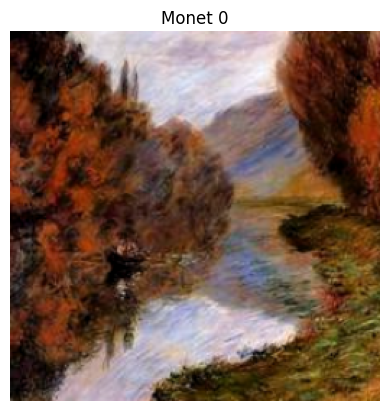

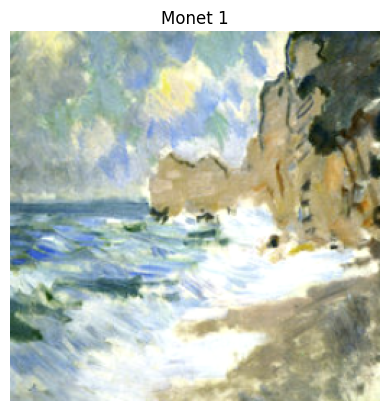

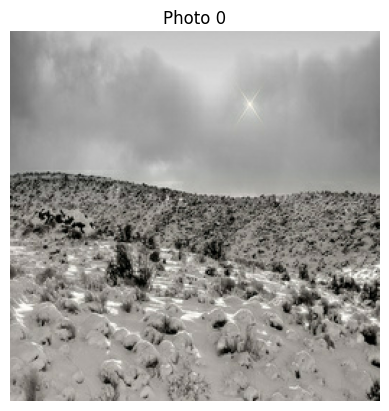

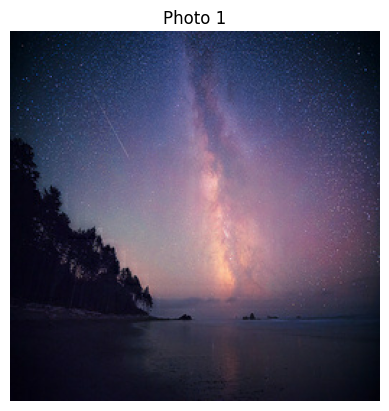

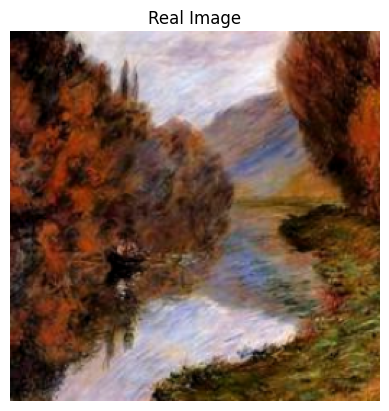

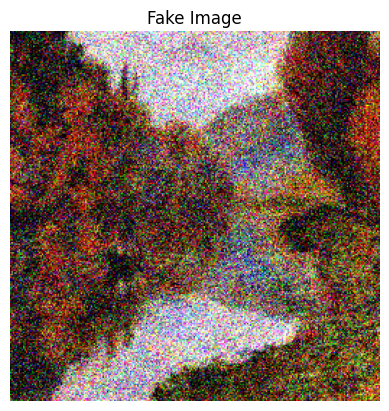

In [14]:
# -------------------------------
# Load multiple Monet and Photo images in one shot
# -------------------------------
monet_indices = [0, 1, 2, 3, 4, 5, 6, 7]
photo_indices = [0, 1]

monet_images = load_image("Monet", image_indices=monet_indices)
photo_images = load_image("Photo", image_indices=photo_indices)

print("Monet Batch Shape:", monet_images.shape, "| dtype:", monet_images.dtype)
print("Photo Batch Shape:", photo_images.shape, "| dtype:", photo_images.dtype)

# -------------------------------
# Plot samples using a loop
# -------------------------------
def plot_multiple(images, title_prefix="Image"):
    for i, img in enumerate(images):
        plot_image(img, title=f"{title_prefix} {i}")

plot_multiple(monet_images[:2], "Monet")
plot_multiple(photo_images[:2], "Photo")

# -------------------------------
# Generate Fake Images by Adding Noise
# -------------------------------
noise_level = 0.5

# Single real/fake
real_image = monet_images[0]
fake_image = np.clip(real_image + np.random.normal(scale=noise_level, size=real_image.shape), -1.0, 1.0)

# Plot real vs fake
plot_image(real_image, title="Real Image")
plot_image(fake_image, title="Fake Image")

# Multiple real and fake images
real_images = np.clip(monet_images, -1.0, 1.0)
fake_images = np.clip(monet_images + np.random.normal(scale=noise_level, size=monet_images.shape), -1.0, 1.0)

In [15]:
def apply_with_dropout(state, x, dropout_key=None, eval_mode=False):
    """
    Universal apply_fn wrapper with safe dropout handling.

    Args:
        state: Flax TrainState with .apply_fn and .params
        x: Input tensor
        dropout_key: jax.random.PRNGKey for stochastic layers (e.g. dropout)
        eval_mode: If True, disables stochastic behavior — but still provides dropout key to satisfy Flax

    Returns:
        Model output
    """
    is_eval = bool(eval_mode)

    if not is_eval and dropout_key is not None:
        return state.apply_fn({'params': state.params}, x, rngs={'dropout': dropout_key})
    elif is_eval:
        key = dropout_key if dropout_key is not None else jax.random.PRNGKey(0)
        return state.apply_fn({'params': state.params}, x, rngs={'dropout': key})
    else:
        return state.apply_fn({'params': state.params}, x)

In [16]:
# Compute FID
import os
import json
import torch
import torch.nn.functional as F
import numpy as np
import jax
import jax.numpy as jnp
from jax import device_put
from torchvision.models import inception_v3, Inception_V3_Weights

# =======================
# Load InceptionV3 Feature Extractor (Torch)
# =======================

def load_inception_feature_extractor():
    """
    Loads the InceptionV3 model for FID computation.
    If weights file exists, loads state_dict; else downloads and saves.
    """
    device = "cpu"

    # Initialize the model with pre-trained weights
    model = inception_v3(weights=Inception_V3_Weights.DEFAULT)
    model.fc = torch.nn.Identity()
    model.eval()
    model = model.to(device)

    if os.path.exists(INCEPTION_V3_FEATURE_MODEL):
        print("Lade gespeicherte InceptionV3-Gewichte (state_dict)...")
        state_dict = torch.load(INCEPTION_V3_FEATURE_MODEL, map_location=device)
        model.load_state_dict(state_dict)
    else:
        print("Lade und speichere neue InceptionV3-Gewichte...")
        torch.save(model.state_dict(), INCEPTION_V3_FEATURE_MODEL)
        print("Gewichte gespeichert unter:", INCEPTION_V3_FEATURE_MODEL)

    print(f"InceptionV3 läuft auf: {device}")
    return model

# =======================
# Batch Preprocessing (Torch-style for TPU-safe pipeline)
# =======================
def preprocess_batch(images):
    """
    [B, H, W, 3] → [B, 3, 299, 299] float32 tensor in [0,1] (TPU-safe preprocessing)

    Args:
        images (np.ndarray or jnp.ndarray): Image batch

    Returns:
        torch.Tensor: Preprocessed tensor
    """
    if not isinstance(images, np.ndarray):
        images = np.asarray(images)  # handles JAX safely

    tensor = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)
    tensor = F.interpolate(tensor, size=(299, 299), mode="bilinear", align_corners=False)
    tensor /= 255.0
    return tensor

# =======================
# Feature Extraction in Batches
# =======================
def extract_features(images, model, batch_size=64):
    features = []
    device = next(model.parameters()).device
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        batch_tensor = preprocess_batch(batch).to(device)
        with torch.no_grad():
            feats = model(batch_tensor).cpu().numpy()
        features.append(feats)
    return np.concatenate(features, axis=0)

# =======================
# TPU-Compatible Matrix Operations (JAX)
# =======================
@jax.jit
def compute_covariance(features):
    batch_size, feature_dim = features.shape
    mean = jnp.mean(features, axis=0, keepdims=True)
    centered = features - mean
    cov = (centered.T @ centered) / (batch_size - 1)
    return cov.astype(jnp.float32)

def sqrtm_eigen(matrix):
    eigvals, eigvecs = jnp.linalg.eigh(matrix)
    eigvals = jnp.maximum(eigvals, 1e-5)
    return eigvecs @ jnp.diag(jnp.sqrt(eigvals)) @ eigvecs.T

@jax.jit
def calculate_fid(mean1, cov1, mean2, cov2):
    eps = 1e-5
    cov1 += jnp.eye(cov1.shape[0]) * eps
    cov2 += jnp.eye(cov2.shape[0]) * eps
    diff = mean1 - mean2
    covmean = sqrtm_eigen(cov1 @ cov2)
    trace = jnp.trace(cov1) + jnp.trace(cov2) - 2 * jnp.trace(covmean)
    return jnp.sum(diff ** 2) + trace

# =======================
# Compute FID with Optional Real Feature Caching
# =======================
def compute_fid(real_images, fake_images, model, batch_size=64, cache_path=None):
    # Normalize
    if float(jnp.max(real_images)) <= 1.0:
        real_images = (real_images * 255).astype(np.uint8)

    if float(jnp.max(fake_images)) <= 1.0:
        fake_images = (fake_images * 255).astype(np.uint8)

    # Real features: Load or compute
    if cache_path and os.path.exists(cache_path):
        with open(cache_path, "rb") as f:
            stats = np.load(f)
            mean_real, cov_real = stats["mean"], stats["cov"]
            mean_real, cov_real = device_put(mean_real), device_put(cov_real)
        print("Loaded real feature stats from cache.")
    else:
        real_feats = device_put(extract_features(real_images, model, batch_size))
        mean_real = jnp.mean(real_feats, axis=0)
        cov_real = compute_covariance(real_feats)
        if cache_path is not None:
            with open(cache_path, "wb") as f:
                np.savez(f, mean=mean_real, cov=cov_real)
            print("Saved real feature stats to cache.")

    # Fake features
    fake_feats = device_put(extract_features(fake_images, model, batch_size))
    mean_fake = jnp.mean(fake_feats, axis=0)
    cov_fake = compute_covariance(fake_feats)

    fid = calculate_fid(mean_real, cov_real, mean_fake, cov_fake)
    return float(fid)

if False:
  # Use for batched Data
  model = load_inception_feature_extractor() # Load before the Epoche loop
  # within the Epoch Loop
  # Evaluate FID
  epoch = 0 # Dummy Epoch
  # After traning the Model
  fid = compute_fid(real_images, fake_images, model, batch_size=64, cache_path="real_stats.npz")
  print(f"Epoch {epoch+1} - FID: {fid:.4f}")

In [17]:
import unittest
import json
import numpy as np
import torch

# ---------- EfficientNet-like FID Test ----------
class TestEfficientNetFunctions(unittest.TestCase):
    def setUp(self):
        self.mean1 = np.random.rand(2048).astype(np.float32)
        self.mean2 = np.random.rand(2048).astype(np.float32)
        A = np.random.randn(2048, 2048).astype(np.float32)
        self.cov1 = A @ A.T + np.eye(2048) * 1e-3
        B = np.random.randn(2048, 2048).astype(np.float32)
        self.cov2 = B @ B.T + np.eye(2048) * 1e-3

    def test_calculate_fid(self):
        fid_score = calculate_fid(self.mean1, self.cov1, self.mean2, self.cov2)
        self.assertIsInstance(float(fid_score), float, "FID score should be a float")
        self.assertGreaterEqual(fid_score, 0.0, "FID should be non-negative")

# ---------- Pipeline/Logging Test ----------
class TestFIDPipeline(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        print("\nLoading InceptionV3 feature extractor...")
        cls.model = load_inception_feature_extractor()

    def generate_mock_images(self, num, size=(256, 256, 3)):
        print("\nGenerating mock images...")
        return np.random.randint(0, 256, size=(num,) + size, dtype=np.uint8)

    def test_fid_computation(self):
        print("\nTesting FID computation...")
        real_images = self.generate_mock_images(8)
        fake_images = self.generate_mock_images(8)

        fid = compute_fid(real_images, fake_images, self.model, batch_size=4)
        self.assertIsInstance(fid, float)
        print(f"FID computed: {fid:.4f}")

In [18]:
import flax.serialization
import os

class CycleGANEarlyStopping:
    """Monitors FID and stops training when no improvement is detected."""
    def __init__(self, patience=10, min_delta=0.005, eval_interval=5, model_save_path="best_generator.msgpack"):
        self.best_fid = float("inf")
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.eval_interval = eval_interval
        self.fid_scores = []
        self.model_save_path = model_save_path

    def check_early_stopping(self, epoch, fid_score, generator_state):
        """Checks if training should stop and saves the best generator params safely."""
        fid_val = float(safe_scalar(fid_score))
        self.fid_scores.append(fid_val)

        print(f"Epoch {epoch}: FID score = {fid_val:.4f}, Best FID = {self.best_fid:.4f}, Wait = {self.wait}")

        if fid_val < self.best_fid - self.min_delta:
            self.best_fid = fid_val
            self.wait = 0

            # ✅ Save params safely using flax.serialization
            with open(self.model_save_path, "wb") as f:
                byte_data = flax.serialization.to_bytes(generator_state.params)
                f.write(byte_data)

            print(f"✅ Best FID Score {fid_score:.4f} - Model saved at Epoch {epoch} → {self.model_save_path}")
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"⏹️ Early stopping triggered at epoch {epoch}.")
                return True

        return False


In [19]:
# Test for Class CycleGANEarlyStopping
import flax.serialization

def test_best_model_saved(self):
    """Tests if the best model is saved when FID improves, and can be reloaded."""
    print("\nTesting best model saving and reloading...")
    self.early_stopping = CycleGANEarlyStopping(patience=3, min_delta=0.05)

    fid_scores = [1.0, 0.9, 0.8, 0.9]  # Simulate FID improvement

    for epoch, fid_score in enumerate(fid_scores):
        self.early_stopping.check_early_stopping(epoch + 1, fid_score, self.dummy_generator_test_state)

    # Check that the file exists
    self.assertTrue(
        os.path.exists(self.early_stopping.model_save_path),
        "Best model file should exist"
    )

    # Try reloading the saved params
    with open(self.early_stopping.model_save_path, "rb") as f:
        loaded_params = flax.serialization.from_bytes(
            self.dummy_generator_test_state.params, f.read()
        )

    # Optional: Compare shapes or structure
    self.assertEqual(
        loaded_params.keys(),
        self.dummy_generator_test_state.params.keys(),
        "Reloaded params should match original structure"
    )
    print("Successfully reloaded generator parameters.")

    def test_loaded_model_generates_output(self):
      """Tests that the reloaded generator can still perform forward pass."""
      print("\nTesting loaded model forward pass...")

      # Simuliere FID und speichere besten Generator
      fid_scores = [1.0, 0.9, 0.8]
      for epoch, fid_score in enumerate(fid_scores):
          self.early_stopping.check_early_stopping(epoch + 1, fid_score, self.dummy_generator_test_state)

      # Lade gespeicherte Parameter
      with open(self.early_stopping.model_save_path, "rb") as f:
          loaded_params = flax.serialization.from_bytes(
              self.dummy_generator_test_state.params,
              f.read()
          )

      # Erzeuge neuen TrainState mit geladenen Parametern
      restored_state = train_state.TrainState.create(
          apply_fn=self.dummy_generator_test.apply,
          params=loaded_params,
          tx=optax.adam(1e-3)
      )

      # Dummy-Eingabe & PRNG
      dummy_input = jnp.zeros((1, 256, 256, 3))
      dropout_key = jax.random.PRNGKey(123)

      # Forward Pass mit apply_fn & Dropout-Key
      output = restored_state.apply_fn(
          {'params': restored_state.params},
          dummy_input,
          rngs={'dropout': dropout_key}
      )

      # Prüfung
      self.assertEqual(output.shape, (1, 256, 256, 3), "Output shape should match input shape")
      print("Loaded model produced output with shape:", output.shape)

In [20]:
# Loss functions
import jax
import jax.numpy as jnp
import optax
import numpy as np
import torch
import torch.nn.functional as F
import json

# ========================
# Adversarial & Cycle Losses (JAX)
# ========================

def adversarial_loss(predictions, target_is_real):
    """
    Computes adversarial loss using binary cross-entropy on logits.

    Args:
        predictions (jnp.ndarray): Discriminator output.
        target_is_real (bool): True if targets should be 'real', False for 'fake'.

    Returns:
        jnp.ndarray: Scalar loss value.
    """
    labels = jnp.where(target_is_real, jnp.ones_like(predictions), jnp.zeros_like(predictions))
    return jnp.mean(optax.sigmoid_binary_cross_entropy(predictions, labels))


def cycle_loss(real_image, cycled_image, lambda_cycle=10.0):
    """
    Cycle consistency loss: L1 distance between original and cycled image.

    Args:
        real_image (jnp.ndarray): Original image.
        cycled_image (jnp.ndarray): Reconstructed image.
        lambda_cycle (float): Weighting factor.

    Returns:
        jnp.ndarray: Scalar loss value.
    """
    return lambda_cycle * jnp.mean(jnp.abs(real_image - cycled_image))


def identity_loss(real_image, same_image, lambda_identity=5.0):
    """
    Identity loss: L1 distance between input and same-domain output.

    Args:
        real_image (jnp.ndarray): Original image.
        same_image (jnp.ndarray): Identity mapping output.
        lambda_identity (float): Weighting factor.

    Returns:
        jnp.ndarray: Scalar loss value.
    """
    return lambda_identity * jnp.mean(jnp.abs(real_image - same_image))


# ========================
# Perceptual Loss (PyTorch)
# ========================

def perceptual_loss_preprocess_batch(images):
    """
    Converts image batch from [B, H, W, 3] to normalized PyTorch tensor [B, 3, 299, 299].

    Args:
        images (np.ndarray or jnp.ndarray): Image batch.

    Returns:
        torch.Tensor: Normalized batch tensor.
    """
    if not isinstance(images, np.ndarray):
        images = np.asarray(images)

    tensor = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)  # safer than from_numpy
    tensor = F.interpolate(tensor, size=(299, 299), mode="bilinear", align_corners=False)
    tensor /= 255.0
    return tensor



@torch.no_grad()
def batch_perceptual_loss(real_images, fake_images, perceptual_model):
    """
    Computes perceptual L1 loss using pretrained InceptionV3 model on batches.

    Args:
        real_images (np.ndarray): Real image batch, shape [B, H, W, 3].
        fake_images (np.ndarray): Fake image batch, shape [B, H, W, 3].
        perceptual_model (torch.nn.Module): Pretrained model.

    Returns:
        float: Perceptual loss value.
    """
    real_tensor = perceptual_loss_preprocess_batch(real_images)
    fake_tensor = perceptual_loss_preprocess_batch(fake_images)

    min_batch = min(real_tensor.shape[0], fake_tensor.shape[0])
    real_tensor = real_tensor[:min_batch]
    fake_tensor = fake_tensor[:min_batch]

    real_features = perceptual_model(real_tensor)
    fake_features = perceptual_model(fake_tensor)

    return torch.mean(torch.abs(real_features - fake_features)).item()


def perceptual_loss(real, fake, model, feature_extractor=None):
    """
    Wrapper that selects between batch or single-image perceptual loss.

    Args:
        real (np.ndarray): Real image(s), shape [H, W, 3] or [B, H, W, 3].
        fake (np.ndarray): Generated image(s), same shape as real.
        model (torch.nn.Module): Pretrained perceptual model (e.g. InceptionV3).
        feature_extractor (Optional[Callable]): Optional feature reducer.

    Returns:
        float: Perceptual loss.
    """
    real = np.asarray(real)
    fake = np.asarray(fake)

    if real.ndim == 4 and fake.ndim == 4:
        return batch_perceptual_loss(real, fake, perceptual_model=model)
    elif real.ndim == 3 and fake.ndim == 3:
        real_tensor = torch.from_numpy(real.copy()).permute(2, 0, 1).unsqueeze(0).float()
        fake_tensor = torch.from_numpy(fake.copy()).permute(2, 0, 1).unsqueeze(0).float()
        real_tensor = F.interpolate(real_tensor, size=(299, 299), mode="bilinear", align_corners=False)
        fake_tensor = F.interpolate(fake_tensor, size=(299, 299), mode="bilinear", align_corners=False)

        device = next(model.parameters()).device
        real_tensor = real_tensor.to(device)
        fake_tensor = fake_tensor.to(device)

        with torch.no_grad():
            real_feat = model(real_tensor)
            fake_feat = model(fake_tensor)

        if feature_extractor is not None:
            real_feat = feature_extractor(real_feat)
            fake_feat = feature_extractor(fake_feat)

        return F.l1_loss(real_feat, fake_feat).item()
    else:
        raise ValueError(f"Shape mismatch: real={real.shape}, fake={fake.shape}")


# ========================
# Logging
# ========================

def log_loss(epoch, losses: dict, log_path="loss_log.jsonl"):
    """
    Appends a JSON line with loss info to a log file.

    Args:
        epoch (int): Current training epoch.
        losses (dict): Dictionary of loss values.
        log_path (str): Path to the log file.
    """
    with open(log_path, "a") as f:
        entry = {"epoch": epoch, **losses}
        f.write(json.dumps(entry) + "\n")

In [21]:
 # Test Suite for Losses
import unittest
import numpy as np
import torch
from torchvision.models import inception_v3, Inception_V3_Weights

class TestLosses(unittest.TestCase):

    @classmethod
    def setUpClass(cls):
        cls.model = inception_v3(weights=Inception_V3_Weights.DEFAULT)
        cls.model.fc = torch.nn.Identity()
        cls.model.eval()
        cls.model.to("cpu")

    def test_adversarial_loss(self):
        pred = jnp.array([0.8, 0.9, 1.0])
        loss_real = adversarial_loss(pred, True)
        loss_fake = adversarial_loss(pred, False)
        self.assertGreaterEqual(loss_fake, 0.0)
        self.assertLess(loss_fake, 5.0)

    def test_cycle_loss(self):
        real = jnp.ones((4, 4, 3))
        cycled = jnp.zeros((4, 4, 3))
        loss = cycle_loss(real, cycled)
        self.assertGreater(loss, 0)

    def test_identity_loss(self):
        real = jnp.ones((4, 4, 3))
        same = jnp.ones((4, 4, 3)) * 0.5
        loss = identity_loss(real, same)
        self.assertGreater(loss, 0)

    def test_perceptual_loss(self):
        real = np.random.randint(0, 256, (256, 256, 3), dtype=np.uint8)
        fake = np.random.randint(0, 256, (256, 256, 3), dtype=np.uint8)
        loss = perceptual_loss(real, fake, self.model)
        loss = float(loss)
        self.assertIsInstance(loss, float)
        self.assertGreaterEqual(loss, 0)

    def test_batch_perceptual_loss(self):
        real = np.random.randint(0, 256, (4, 256, 256, 3), dtype=np.uint8)
        fake = np.random.randint(0, 256, (4, 256, 256, 3), dtype=np.uint8)
        loss = batch_perceptual_loss(real, fake, self.model)
        loss = float(loss)
        self.assertIsInstance(loss, float)
        self.assertGreaterEqual(loss, 0)

    def test_log_loss(self):
        log_path = "test_loss_log.jsonl"
        log_loss(1, {"adv": 0.3, "cyc": 1.2}, log_path=log_path)
        with open(log_path, "r") as f:
            last = eval(f.readlines()[-1])
        self.assertEqual(last["epoch"], 1)
        self.assertIn("adv", last)
        self.assertIn("cyc", last)

In [22]:
def generator_loss_fn_eval(
    real_monet,
    real_photo,
    fake_monet,
    fake_photo,
    cycle_monet,
    cycle_photo,
    same_monet,
    same_photo,
    monet_logits,
    photo_logits,
    perceptual_model=None,

    lambda_adversarial_photo=1.0,
    lambda_adversarial_monet=1.0,
    lambda_cycle_photo=10.0,
    lambda_cycle_monet=10.0,
    lambda_identity_photo=5.0,
    lambda_identity_monet=5.0,
    lambda_perceptual=1.0,

    return_all=False
):
    # Cast inputs to bfloat16 for memory-efficient training
    real_photo = real_photo.astype(jnp.bfloat16)
    real_monet = real_monet.astype(jnp.bfloat16)
    if cycle_photo is not None: cycle_photo = cycle_photo.astype(jnp.bfloat16)
    if cycle_monet is not None: cycle_monet = cycle_monet.astype(jnp.bfloat16)
    if same_photo is not None: same_photo = same_photo.astype(jnp.bfloat16)
    if same_monet is not None: same_monet = same_monet.astype(jnp.bfloat16)

    # === Adversarial Loss ===
    adv_photo_loss = jnp.mean(optax.sigmoid_binary_cross_entropy(photo_logits, jnp.ones_like(photo_logits)))
    adv_monet_loss = jnp.mean(optax.sigmoid_binary_cross_entropy(monet_logits, jnp.ones_like(monet_logits)))

    # === Cycle Consistency Loss ===
    cycle_loss_photo = jnp.mean(jnp.abs(real_photo - cycle_photo))
    cycle_loss_monet = jnp.mean(jnp.abs(real_monet - cycle_monet))

    # === Identity Loss ===
    identity_loss_photo = jnp.mean(jnp.abs(real_photo - same_photo))
    identity_loss_monet = jnp.mean(jnp.abs(real_monet - same_monet))

    # === Perceptual Loss (Optional) ===
    perc_loss_photo = perceptual_loss(real_photo, fake_photo, perceptual_model) if perceptual_model else 0.0
    perc_loss_monet = perceptual_loss(real_monet, fake_monet, perceptual_model) if perceptual_model else 0.0

    # === Total Generator Losses ===
    g_loss = (
        lambda_adversarial_photo * adv_photo_loss +
        lambda_cycle_photo * cycle_loss_photo +
        lambda_identity_photo * identity_loss_photo +
        lambda_perceptual * perc_loss_photo
    )

    f_loss = (
        lambda_adversarial_monet * adv_monet_loss +
        lambda_cycle_monet * cycle_loss_monet +
        lambda_identity_monet * identity_loss_monet +
        lambda_perceptual * perc_loss_monet
    )

    if return_all:
        return {
            "g_loss": g_loss,
            "f_loss": f_loss,
            "adv_photo": adv_photo_loss,
            "adv_monet": adv_monet_loss,
            "cycle_photo": cycle_loss_photo,
            "cycle_monet": cycle_loss_monet,
            "identity_photo": identity_loss_photo,
            "identity_monet": identity_loss_monet,
            "perc_photo": jnp.array(perc_loss_photo),
            "perc_monet": jnp.array(perc_loss_monet),
        }
    else:
        return g_loss, f_loss

In [23]:
from typing import NamedTuple
import jax.numpy as jnp

class GeneratorLosses(NamedTuple):
    g_loss: jnp.ndarray
    f_loss: jnp.ndarray
    adv_photo: jnp.ndarray
    adv_monet: jnp.ndarray
    cycle_photo: jnp.ndarray
    cycle_monet: jnp.ndarray
    identity_photo: jnp.ndarray
    identity_monet: jnp.ndarray
    perc_photo: jnp.ndarray
    perc_monet: jnp.ndarray

def generator_loss_fn_train(
    real_monet,
    real_photo,
    generator_A2B_state,
    generator_B2A_state,
    photo_disc,
    monet_disc,
    dropout_rng_A2B,
    dropout_rng_B2A,
    params_a2b,
    params_b2a,
    global_step,
    config,
    fid_model=None,
    return_all=True,
    lambda_adversarial_photo=1.0,
    lambda_cycle_photo=10.0,
    lambda_identity_photo=5.0,
    lambda_adversarial_monet=1.0,
    lambda_cycle_monet=10.0,
    lambda_identity_monet=5.0
  ):
    generator_a2b = generator_A2B_state.apply_fn
    generator_b2a = generator_B2A_state.apply_fn

    # Fake generations
    fake_photo   = generator_a2b({"params": params_a2b}, real_monet, rngs={"dropout": dropout_rng_A2B})
    fake_monet   = generator_b2a({"params": params_b2a}, real_photo, rngs={"dropout": dropout_rng_B2A})
    cycle_photo  = generator_a2b({"params": params_a2b}, fake_monet, rngs={"dropout": dropout_rng_A2B})
    cycle_monet  = generator_b2a({"params": params_b2a}, fake_photo, rngs={"dropout": dropout_rng_B2A})
    same_photo   = generator_a2b({"params": params_a2b}, real_photo, rngs={"dropout": dropout_rng_A2B})
    same_monet   = generator_b2a({"params": params_b2a}, real_monet, rngs={"dropout": dropout_rng_B2A})

    # Speicher sparen – keine Gradienten nötig
    cycle_photo = jax.lax.stop_gradient(cycle_photo)
    cycle_monet = jax.lax.stop_gradient(cycle_monet)
    same_photo  = jax.lax.stop_gradient(same_photo)
    same_monet  = jax.lax.stop_gradient(same_monet)

    # Discriminator outputs
    photo_logits = photo_disc.apply_fn({'params': photo_disc.params}, fake_photo)[0]
    monet_logits = monet_disc.apply_fn({'params': monet_disc.params}, fake_monet)[0]

    # Adversarial losses
    adv_photo_loss = jnp.mean(optax.sigmoid_binary_cross_entropy(photo_logits, jnp.ones_like(photo_logits)))
    adv_monet_loss = jnp.mean(optax.sigmoid_binary_cross_entropy(monet_logits, jnp.ones_like(monet_logits)))

    # Cycle losses
    cycle_loss_photo = jnp.mean(jnp.abs(real_photo - cycle_photo))
    cycle_loss_monet = jnp.mean(jnp.abs(real_monet - cycle_monet))

    # Identity losses
    identity_loss_photo = jnp.mean(jnp.abs(real_photo - same_photo))
    identity_loss_monet = jnp.mean(jnp.abs(real_monet - same_monet))

    # Base loss terms
    g_loss = (
        lambda_adversarial_photo * adv_photo_loss +
        lambda_cycle_photo * cycle_loss_photo +
        lambda_identity_photo * identity_loss_photo
    )
    f_loss = (
        lambda_adversarial_monet * adv_monet_loss +
        lambda_cycle_monet * cycle_loss_monet +
        lambda_identity_monet * identity_loss_monet
    )

    # Optional perceptual loss
    perc_photo = jnp.array(0.0)
    perc_monet = jnp.array(0.0)

    return GeneratorLosses(
        g_loss=g_loss,
        f_loss=f_loss,
        adv_photo=adv_photo_loss,
        adv_monet=adv_monet_loss,
        cycle_photo=cycle_loss_photo,
        cycle_monet=cycle_loss_monet,
        identity_photo=identity_loss_photo,
        identity_monet=identity_loss_monet,
        perc_photo=perc_photo,
        perc_monet=perc_monet,
    )

In [24]:
import jax
import jax.numpy as jnp
import optax
from typing import NamedTuple

def safe_mean(x, eps=1e-7):
    return jnp.mean(jnp.clip(x, a_min=eps, a_max=1e6))

class DiscriminatorLosses(NamedTuple):
    total_loss: jnp.ndarray
    adv_loss: jnp.ndarray
    r1_loss: jnp.ndarray
    fm_loss: jnp.ndarray

def discriminator_loss_fn(
    real_images, fake_images,
    disc_real_output, disc_fake_output,
    real_features, fake_features,
    discriminator,
    lambda_r1=0.0,
    lambda_fm=0.0,
    global_step=None,
):
    dtype = real_images.dtype

    disc_real_output = disc_real_output.astype(dtype)
    disc_fake_output = disc_fake_output.astype(dtype)
    real_features = real_features.astype(dtype)
    fake_features = fake_features.astype(dtype)

    seed = int(global_step) if global_step is not None else 0
    key_real, key_fake, key_r1 = jax.random.split(jax.random.PRNGKey(seed), 3)

    real_labels = jax.random.uniform(key_real, shape=disc_real_output.shape, minval=0.8, maxval=1.0)
    fake_labels = jnp.zeros_like(disc_fake_output)

    real_loss = safe_mean(optax.sigmoid_binary_cross_entropy(disc_real_output, real_labels))
    fake_loss = safe_mean(optax.sigmoid_binary_cross_entropy(disc_fake_output, fake_labels))
    adv_loss = real_loss + fake_loss

    r1_loss = jnp.array(0.0, dtype=dtype)
    if lambda_r1 > 0:
        def compute_logits_sum(x):
            logits, _ = discriminator.apply_fn(
                {"params": discriminator.params}, x,
                rngs={"dropout": key_r1}
            )
            return jnp.sum(logits)
        grad_input = real_images.astype(jnp.float32) if dtype == jnp.bfloat16 else real_images
        grads = jax.grad(compute_logits_sum)(grad_input)
        r1_loss = safe_mean(jnp.square(grads)) * (lambda_r1 / 2)

    fm_loss = jnp.array(0.0, dtype=dtype)
    if lambda_fm > 0:
        fm_loss = safe_mean(jnp.abs(real_features - fake_features)) * lambda_fm

    total_loss = adv_loss + r1_loss + fm_loss

    return DiscriminatorLosses(
        total_loss=total_loss,
        adv_loss=adv_loss,
        r1_loss=r1_loss,
        fm_loss=fm_loss
    )

In [ ]:
import unittest
import jax.numpy as jnp
import jax
import numpy as np
import flax.linen as nn
from flax.training import train_state
import optax
import flax.serialization
import os

# === Dummy Generator ===
class DummyGenerator(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(3, (7, 7), padding='SAME')(x)
        return nn.sigmoid(x)

# === Mock Discriminator ===
class MockDiscriminator:
    def __init__(self):
        self.params = {}

    def apply_fn(self, variables, x):
        logits = jnp.ones((x.shape[0], 1)) * 0.8
        features = jnp.ones((x.shape[0], 64, 64, 128)) * 0.5
        return logits, features

# === Testklasse ===
class TestCycleGANLosses(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        print("Setting up test environment...")

        cls.real_monet = jnp.ones((4, 64, 64, 3))
        cls.real_photo = jnp.ones((4, 64, 64, 3)) * 0.9
        cls.cycle_monet = cls.real_monet * 0.95
        cls.cycle_photo = cls.real_photo * 0.95
        cls.same_monet = cls.real_monet
        cls.same_photo = cls.real_photo

        dummy_input = jnp.ones((4, 64, 64, 3))
        model_A2B = DummyGenerator()
        model_B2A = DummyGenerator()

        rng = jax.random.PRNGKey(0)
        params_A2B = model_A2B.init({'params': rng, 'dropout': rng}, dummy_input)['params']
        params_B2A = model_B2A.init({'params': rng, 'dropout': rng}, dummy_input)['params']
        tx = optax.adam(1e-4)

        cls.gen_A2B = train_state.TrainState.create(apply_fn=model_A2B.apply, params=params_A2B, tx=tx)
        cls.gen_B2A = train_state.TrainState.create(apply_fn=model_B2A.apply, params=params_B2A, tx=tx)

        key1, key2 = jax.random.split(jax.random.PRNGKey(42))
        cls.fake_photo = apply_with_dropout(cls.gen_A2B, cls.real_monet, dropout_key=key1)
        cls.fake_monet = apply_with_dropout(cls.gen_B2A, cls.real_photo, dropout_key=key2)

        cls.monet_disc = MockDiscriminator()
        cls.photo_disc = MockDiscriminator()

        cls.model_save_path = "test_best_generator.msgpack"

    def tearDown(self):
        if os.path.exists(self.model_save_path):
            os.remove(self.model_save_path)

    def test_forward_after_reload(self):
        """Saves & reloads generator, tests forward output shape."""
        # 1. Save model
        with open(self.model_save_path, "wb") as f:
            data = flax.serialization.to_bytes(self.gen_A2B.params)
            f.write(data)

        # 2. Reload model
        with open(self.model_save_path, "rb") as f:
            restored_params = flax.serialization.from_bytes(self.gen_A2B.params, f.read())

        restored_state = train_state.TrainState.create(
            apply_fn=self.gen_A2B.apply_fn,
            params=restored_params,
            tx=self.gen_A2B.tx
        )

        # 3. Run inference
        dummy_input = jnp.ones((1, 256, 256, 3))
        out = apply_with_dropout(restored_state, dummy_input, dropout_key=jax.random.PRNGKey(0))

        self.assertEqual(out.shape, (1, 256, 256, 3))
        print("Reloaded generator works. Output shape:", out.shape)

Setting up test environment...


.

Reloaded generator works. Output shape: (1, 256, 256, 3)


.


Loading InceptionV3 feature extractor...
Lade gespeicherte InceptionV3-Gewichte (state_dict)...
InceptionV3 läuft auf: cpu

Testing FID computation...

Generating mock images...

Generating mock images...


In [ ]:
# Generator GeneratorV2()import jax
import jax.numpy as jnp
from flax import linen as nn
from typing import Any


# -----------------------
# Residual Block (V2)
# -----------------------
class ResidualBlockV2(nn.Module):
    channels: int
    norm: bool = True
    dropout_rate: float = 0.0
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, x):
        residual = x
        x = nn.Conv(self.channels, (3, 3), padding='SAME', use_bias=False, dtype=self.dtype)(x)
        if self.norm:
            x = nn.InstanceNorm(dtype=self.dtype)(x)
        x = nn.relu(x)
        if self.dropout_rate > 0:
            x = nn.Dropout(self.dropout_rate)(x, deterministic=False)
        x = nn.Conv(self.channels, (3, 3), padding='SAME', use_bias=False, dtype=self.dtype)(x)
        if self.norm:
            x = nn.InstanceNorm(dtype=self.dtype)(x)

        if residual.shape[-1] != self.channels:
            residual = nn.Conv(self.channels, (1, 1), padding='SAME', use_bias=False, dtype=self.dtype)(residual)

        return x + residual


# -----------------------
# CBAM Attention Module
# -----------------------
class ChannelAttention(nn.Module):
    channels: int
    reduction_ratio: int = 16
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, x):
        avg_pool = jnp.mean(x, axis=(1, 2), keepdims=True)
        max_pool = jnp.max(x, axis=(1, 2), keepdims=True)

        shared_mlp = nn.Sequential([
            nn.Dense(self.channels // self.reduction_ratio, dtype=self.dtype),
            nn.relu,
            nn.Dense(self.channels, dtype=self.dtype),
        ])

        avg_out = shared_mlp(avg_pool)
        max_out = shared_mlp(max_pool)

        scale = nn.sigmoid(avg_out + max_out)
        return x * scale


class SpatialAttention(nn.Module):
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, x):
        avg_pool = jnp.mean(x, axis=-1, keepdims=True)
        max_pool = jnp.max(x, axis=-1, keepdims=True)
        concat = jnp.concatenate([avg_pool, max_pool], axis=-1)

        scale = nn.Conv(
            features=1,
            kernel_size=(7, 7),
            strides=(1, 1),
            padding='SAME',
            use_bias=False,
            dtype=self.dtype
        )(concat)

        scale = nn.sigmoid(scale)
        return x * scale


class CBAM(nn.Module):
    channels: int
    reduction_ratio: int = 16
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, x):
        x = ChannelAttention(self.channels, self.reduction_ratio, dtype=self.dtype)(x)
        x = SpatialAttention(dtype=self.dtype)(x)
        return x


# -----------------------
# Generator V2 (Enhanced)
# -----------------------
class GeneratorV2(nn.Module):
    use_attention: bool = False
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, x):
        skips = []

        # Initial Conv
        x = nn.Conv(64, (7, 7), padding='SAME', dtype=self.dtype, use_bias=False)(x)
        x = nn.InstanceNorm(dtype=self.dtype)(x)
        x = nn.relu(x)
        skips.append(x)

        # Downsampling
        for ch in [64, 128]: ### von [128, 256] auf [64, 128] setzen, um Speicher zu sparen.
            x = nn.Conv(ch, (3, 3), strides=(2, 2), padding='SAME', dtype=self.dtype, use_bias=False)(x)
            x = nn.InstanceNorm(dtype=self.dtype)(x)
            x = nn.relu(x)
            skips.append(x)

        # Residual Bottleneck
        for _ in range(9): #### Von 9 auf 1 reduziert, um Speicher zu sparen.
            x = ResidualBlockV2(256, dropout_rate=0.1, dtype=self.dtype)(x)

        # Optional CBAM Attention
        if self.use_attention:
            x = CBAM(256, dtype=self.dtype)(x)

        # Upsampling
        for i, ch in enumerate([64, 32]): ### von [128, 64] auf [64, 32] setzen, um Speicher zu sparen.
            if x.ndim == 4:
                new_shape = (x.shape[0], x.shape[1]*2, x.shape[2]*2, x.shape[3])
                x = jax.image.resize(x, new_shape, method='bilinear')
            else:
                raise ValueError(f"Expected 4D input for resize, got shape: {x.shape}")
            x = nn.Conv(ch, (3, 3), padding='SAME', dtype=self.dtype, use_bias=False)(x)
            x = nn.InstanceNorm(dtype=self.dtype)(x)
            x = nn.relu(x)

            # Skip-Add mit Shape-Fix
            skip = skips[-(i+2)]
            if skip.shape[-1] != x.shape[-1]:
                skip = nn.Conv(x.shape[-1], kernel_size=(1, 1), padding='SAME', dtype=self.dtype)(skip)
            x = x + skip

        # Output layer
        x = nn.Conv(3, (7, 7), padding='SAME', use_bias=False, dtype=self.dtype)(x)
        x = nn.tanh(x)
        return x

In [ ]:
# Discriminiator ConfigurableDiscriminator()
import flax.linen as nn
import jax.numpy as jnp
from typing import Tuple, Any

class ConfigurableDiscriminator(nn.Module):
    """
    Configurable Multi-Scale PatchGAN Discriminator.

    Parameters:
        base_features (int): Number of filters in the first conv layer (default 64).
        num_layers (int): How many downsampling layers to use (controls patch size).
        use_feature_output (bool): If True, return intermediate features for perceptual loss.
    """
    base_features: int = 64
    num_layers: int = 3
    use_feature_output: bool = True
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, x: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray]:
        """
        Forward pass of the discriminator.

        Args:
            x: Input image tensor (B, H, W, C)

        Returns:
            Tuple of:
                - Patch-based discriminator output (B, H', W', 1)
                - Intermediate features before final layer (if use_feature_output=True)
        """
        features = None
        nf = self.base_features

        # Initial convolution without normalization
        x = nn.Conv(features=nf, kernel_size=(4, 4), strides=(2, 2), padding='SAME', dtype=self.dtype)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)

        # Downsampling blocks with increasing filters
        for i in range(1, self.num_layers):
            nf = min(nf * 2, 512)  # cap feature maps at 512
            x = nn.Conv(features=nf, kernel_size=(4, 4), strides=(2, 2), padding='SAME', dtype=self.dtype, use_bias=False)(x)
            x = nn.InstanceNorm()(x)
            x = nn.leaky_relu(x, negative_slope=0.2)

        # Final block with stride 1 (preserves spatial dimensions)
        nf = min(nf * 2, 512)
        x = nn.Conv(features=nf, kernel_size=(4, 4), strides=(1, 1), padding='SAME', dtype=self.dtype, use_bias=False)(x)
        x = nn.InstanceNorm()(x)
        x = nn.leaky_relu(x, negative_slope=0.2)

        # Store features before last conv if needed
        if self.use_feature_output:
            features = x

        # Output PatchGAN prediction: (B, H', W', 1)
        out = nn.Conv(features=1, kernel_size=(4, 4), strides=(1, 1), padding='SAME', dtype=self.dtype)(x)

        return out, features if self.use_feature_output else jnp.zeros_like(out)

In [ ]:
import os
import matplotlib.pyplot as plt

def plot_generator_loss_components_monets(log, epoch, step=None, save_dir=OUTPUT_DIRS["gen_loss_monet"], title="Generator Loss Components (Monet→Photo)"):
    os.makedirs(save_dir, exist_ok=True)

    plt.figure(figsize=(10, 6))
    plt.plot(log["step"], log["f_loss"], marker="o", label="Total F Loss (Monet→Photo)")
    plt.plot(log["step"], log["adv_monet"], marker="o", label="Adversarial Monet")
    plt.plot(log["step"], log["cycle_monet"], marker="o", linestyle="--", linewidth=2, alpha=0.9, label="Cycle Monet", zorder=5)
    plt.plot(log["step"], log["identity_monet"], marker="o", label="Identity Monet")
    plt.plot(log["step"], log["perc_monet"], marker="o", label="Perceptual Monet")

    plt.xlabel("Global Step")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    suffix = f"epoch_{epoch:04d}_step_{step:06d}" if step is not None else f"step_{log['step'][-1]:06d}"
    filename = os.path.join(save_dir, f"generator_loss_monet_{suffix}.png")
    plt.savefig(filename)
    plt.close()


def plot_generator_loss_components_photos(log, epoch, step=None, save_dir=OUTPUT_DIRS["gen_loss_photo"], title="Generator Loss Components (Photo→Monet)"):
    os.makedirs(save_dir, exist_ok=True)

    plt.figure(figsize=(10, 6))
    plt.plot(log["step"], log["f_loss"], marker="o", label="Total F Loss (Photo→Monet)")
    plt.plot(log["step"], log["adv_photo"], marker="o", label="Adversarial Photo")
    plt.plot(log["step"], log["cycle_photo"], marker="o", linestyle="--", linewidth=2, alpha=0.9, label="Cycle Photo", zorder=5)
    plt.plot(log["step"], log["identity_photo"], marker="o", label="Identity Photo")
    plt.plot(log["step"], log["perc_photo"], marker="o", label="Perceptual Photo")

    plt.xlabel("Global Step")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    suffix = f"epoch_{epoch:04d}_step_{step:06d}" if step is not None else f"step_{log['step'][-1]:06d}"
    filename = os.path.join(save_dir, f"generator_loss_photo_{suffix}.png")
    plt.savefig(filename)
    plt.close()

In [ ]:
# --------------------------------
# CycleGan Factory
# --------------------------------

import jax
import jax.numpy as jnp
from flax.training import train_state
import optax
import time
import gc
from flax.jax_utils import replicate

class CycleGANFactory:
    """
    Factory class to create CycleGAN models (generators and discriminators)
    along with their TrainState objects.
    """
    def __init__(
        self,
        gen_class,
        disc_class,
        input_shape=(1, 256, 256, 3),
        gen_kwargs=None,
        disc_kwargs=None,
        gen_optimizer=None,
        disc_optimizer=None,
        prng_seed=0
    ):
        self.gen_class = gen_class
        self.disc_class = disc_class
        self.input_shape = input_shape
        self.gen_kwargs = gen_kwargs or {}
        self.disc_kwargs = disc_kwargs or {}
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.prng_seed = prng_seed

    def _init_model_state(self, model, key, dummy_input, optimizer):
        """
        Helper method to initialize a model's TrainState.
        """
        key, dropout_key = jax.random.split(key)
        try:
            print(f"Initializing model {model.__class__.__name__}...")
            variables = model.init({'params': key, 'dropout': dropout_key}, dummy_input)
            params = variables['params']
            return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)
        except Exception as e:
            print(f"Model initialization failed for {model.__class__.__name__}: {e}")
            return None

    def _safe_replicate(self, state, name=""):
        try:
            print(f"Replicating {name}...")
            replicated = replicate(state)
            gc.collect()
            time.sleep(0.5)
            return replicated
        except Exception as e:
            print(f"❌ Failed to replicate {name}: {type(e).__name__} - {e}")
            raise

    def build(self, replicate_states: bool = True):
        """
        Builds and returns the TrainState objects for both generators and discriminators.

        Args:
            replicate_states (bool): If True, replicate the states across devices for pmap.

        Returns:
            Tuple of replicated (or regular) TrainState objects:
                (generator_A2B_state, generator_B2A_state, discriminator_A_state, discriminator_B_state)
        """
        dummy_input = jnp.zeros(self.input_shape, dtype=jnp.float32)
        key = jax.random.PRNGKey(self.prng_seed)
        gen_key1, gen_key2, disc_key1, disc_key2 = jax.random.split(key, 4)

        generator_A2B = self.gen_class(**self.gen_kwargs)
        generator_B2A = self.gen_class(**self.gen_kwargs)
        discriminator_A = self.disc_class(**self.disc_kwargs)
        discriminator_B = self.disc_class(**self.disc_kwargs)

        generator_A2B_state = self._init_model_state(generator_A2B, gen_key1, dummy_input, self.gen_optimizer)
        generator_B2A_state = self._init_model_state(generator_B2A, gen_key2, dummy_input, self.gen_optimizer)
        discriminator_A_state = self._init_model_state(discriminator_A, disc_key1, dummy_input, self.disc_optimizer)
        discriminator_B_state = self._init_model_state(discriminator_B, disc_key2, dummy_input, self.disc_optimizer)

        if replicate_states:
            generator_A2B_state = self._safe_replicate(generator_A2B_state, "Generator A2B")
            generator_B2A_state = self._safe_replicate(generator_B2A_state, "Generator B2A")
            discriminator_A_state = self._safe_replicate(discriminator_A_state, "Discriminator A")
            discriminator_B_state = self._safe_replicate(discriminator_B_state, "Discriminator B")

        return generator_A2B_state, generator_B2A_state, discriminator_A_state, discriminator_B_state

    def create_generator(self):
      """Returns a fresh generator instance with injected kwargs."""
      return self.gen_class(**self.gen_kwargs)

    def create_discriminator(self):
        """Returns a fresh discriminator instance with injected kwargs."""
        return self.disc_class(**self.disc_kwargs)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def normalize(values):
    values = np.array(values)
    return (values - np.nanmin(values)) / (np.nanmax(values) - np.nanmin(values) + 1e-8)

def plot_domain_losses(log, disc_log, step=None, epoch=None, title="G vs. D Loss per Domain (normalized)", save_dir=OUTPUT_DIRS["combined_loss"]):
    os.makedirs(save_dir, exist_ok=True)

    df_g = pd.DataFrame(log)
    df_d = pd.DataFrame(disc_log)
    df_d = df_d.set_index("step").reindex(df_g["step"]).ffill().reset_index()

    # Normalize losses, skipping NaNs
    norm_g_photo = normalize(df_g["adv_photo"])
    norm_d_photo = normalize(df_d["d_loss_photo"])
    norm_g_monet = normalize(df_g["adv_monet"])
    norm_d_monet = normalize(df_d["d_loss_monet"])

    suffix = f"epoch_{epoch:04d}" if epoch is not None else f"step_{(step or df_g['step'].iloc[-1]):06d}"

    def plot_single(domain, g_vals, d_vals, label_g, label_d, fname):
        plt.figure(figsize=(6, 4))
        plt.plot(df_g["step"], g_vals, marker="o", linestyle="--", label=label_g)
        plt.plot(df_g["step"], d_vals, marker="o", linestyle="-", label=label_d)
        plt.title(f"{domain} Domain")
        plt.xlabel("Global Step")
        plt.ylabel("Normalized Loss")
        plt.legend()
        plt.grid(True)
        full_path = os.path.join(save_dir, fname)
        plt.savefig(full_path)
        plt.close()

    # Combined domain plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].plot(df_g["step"], norm_g_photo, marker="o", linestyle="--", label="G_A2B (Photo)")
    axs[0].plot(df_g["step"], norm_d_photo, marker="o", linestyle="-", label="D_B (Photo)")
    axs[0].set_title("Photo Domain")
    axs[0].set_xlabel("Global Step")
    axs[0].set_ylabel("Normalized Loss")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(df_g["step"], norm_g_monet, marker="o", linestyle="--", label="G_B2A (Monet)")
    axs[1].plot(df_g["step"], norm_d_monet, marker="o", linestyle="-", label="D_A (Monet)")
    axs[1].set_title("Monet Domain")
    axs[1].set_xlabel("Global Step")
    axs[1].set_ylabel("Normalized Loss")
    axs[1].legend()
    axs[1].grid(True)

    fig.suptitle(title)
    fig.tight_layout()
    combined_path = os.path.join(save_dir, f"combined_loss_plot_{suffix}.png")
    fig.savefig(combined_path)
    plt.close(fig)

    # Individual domain plots
    plot_single("Photo", norm_g_photo, norm_d_photo, "G_A2B (Photo)", "D_B (Photo)", f"photo_loss_plot_{suffix}.png")
    plot_single("Monet", norm_g_monet, norm_d_monet, "G_B2A (Monet)", "D_A (Monet)", f"monet_loss_plot_{suffix}.png")

In [ ]:
from dataclasses import dataclass, field
from typing import Union, Callable
import flax.linen as nn
from typing import Optional

@dataclass
class TrainConfig:
    # Training Hyperparameters
    max_epochs: int = 200
    batch_size: int = 1
    early_stopping_patience: int = 20
    save_interval: int = 5

    # Directory Paths
    checkpoint_dir: str = ""
    log_dir: str = ""
    fid_plot_dir: str = ""
    combined_loss_dir: str = ""
    original_vs_fake_dir: str = ""
    gen_loss_monet_dir: str = ""
    gen_loss_photo_dir: str = ""
    grad_norms_dir: str = ""
    schedules_dir: str = ""
    loss_vs_grad_norm_dir: str = ""

    # Model Factory and Checkpointing
    factory: Optional["CycleGANFactory"] = None
    load_checkpoint_step: Optional[int] = None
    eval_deterministic: bool = True
    enable_perceptual: bool = True

    # Loss Schedules (can be float or callable)
    adv_photo_schedule: Union[float, Callable[[int], float]] = 0.4
    adv_monet_schedule: Union[float, Callable[[int], float]] = 0.4
    cycle_photo_schedule: Union[float, Callable[[int], float]] = 12.0
    cycle_monet_schedule: Union[float, Callable[[int], float]] = 12.0
    identity_photo_schedule: Union[float, Callable[[int], float]] = 5.0
    identity_monet_schedule: Union[float, Callable[[int], float]] = 5.0
    perceptual_schedule: Union[float, Callable[[int], float]] = 1.0

    # Regularization Parameters
    lambda_r1_A: float = 3.0
    lambda_r1_B: float = 4.0
    lambda_fm_A: float = 1.0
    lambda_fm_B: float = 1.0

    def __post_init__(self):
        # Automatically wrap float schedules in lambdas
        for field_name in [
            "adv_photo_schedule", "adv_monet_schedule",
            "cycle_photo_schedule", "cycle_monet_schedule",
            "identity_photo_schedule", "identity_monet_schedule",
            "perceptual_schedule"
        ]:
            val = getattr(self, field_name)
            if not callable(val):
                setattr(self, field_name, lambda step, v=val: v)

    # Model Modules via Factory
    @property
    def generator_A2B_module(self):
        return self.factory.create_generator()

    @property
    def generator_B2A_module(self):
        return self.factory.create_generator()

    @property
    def discriminator_A_module(self):
        return self.factory.create_discriminator()

    @property
    def discriminator_B_module(self):
        return self.factory.create_discriminator()

    @property
    def gen_optimizer(self):
        return self.factory.gen_optimizer

    @property
    def disc_optimizer(self):
        return self.factory.disc_optimizer

    @property
    def perceptual_enabled(self):
        return self.enable_perceptual

# ----------------------------------------
# Loss Scheduling Utilities
# ----------------------------------------
import numpy as np

def cosine_schedule_fn(start: float, end: float, total_steps: int, warmup_steps: int = 0):
    def schedule(step: int):
        step = min(step, warmup_steps + total_steps)
        if step < warmup_steps:
            return (step / warmup_steps) * start
        step_adj = step - warmup_steps
        cosine = 0.5 * (1 + np.cos(np.pi * step_adj / total_steps))
        return end + (start - end) * cosine
    return schedule

# ----------------------------------------
# Instantiate Configuration
# ----------------------------------------
config = TrainConfig()

# ----------------------------------------
# Compute total training steps
# ----------------------------------------
num_train_images = 5630  # From your dataset
steps_per_epoch = num_train_images // config.batch_size
total_steps = config.max_epochs * steps_per_epoch

# ----------------------------------------
# Define dynamic loss schedules
# ----------------------------------------
config.adv_photo_schedule = cosine_schedule_fn(0.2, 0.5, total_steps, warmup_steps=1000)
config.adv_monet_schedule = 0.4  # Constant value

config.cycle_photo_schedule = cosine_schedule_fn(10.0, 5.0, total_steps, warmup_steps=1000)
config.cycle_monet_schedule = 12.0  # Constant value

config.identity_photo_schedule = cosine_schedule_fn(6.0, 2.0, total_steps, warmup_steps=1000)
config.identity_monet_schedule = cosine_schedule_fn(8.0, 3.0, total_steps, warmup_steps=1000)

config.perceptual_schedule = cosine_schedule_fn(0.3, 0.0, total_steps, warmup_steps=500)


# ----------------------------------------
# LossConfig class
# ----------------------------------------
class LossConfig:
    def __init__(self, config: TrainConfig):
        self.generator_a2b = config.generator_A2B_module
        self.generator_b2a = config.generator_B2A_module

        # Schedules
        self.adv_photo = config.adv_photo_schedule
        self.adv_monet = config.adv_monet_schedule
        self.cycle_photo = config.cycle_photo_schedule
        self.cycle_monet = config.cycle_monet_schedule
        self.identity_photo = config.identity_photo_schedule
        self.identity_monet = config.identity_monet_schedule
        self.perceptual = config.perceptual_schedule

        # Regularization Parameters
        self.r1_A = config.lambda_r1_A
        self.r1_B = config.lambda_r1_B
        self.fm_A = config.lambda_fm_A
        self.fm_B = config.lambda_fm_B

    def _get(self, value_or_fn, step):
        val = value_or_fn(step) if callable(value_or_fn) else value_or_fn
        if step is not None and step % 80 == 0:
            print(f"🔎 λ schedule at step {step}: {val}")
        return val

    def compute_generator(self,
                          real_monet, real_photo,
                          monet_disc, photo_disc,
                          generator_A2B_state,
                          generator_B2A_state,
                          global_step=None,
                          return_all=False,
                          dropout_rng=None,
                          params_a2b=None,
                          params_b2a=None,
                          config=None,
                          fid_model=None):

        if isinstance(dropout_rng, tuple):
            dropout_rng_A2B, dropout_rng_B2A = dropout_rng
        else:
            dropout_rng_A2B = dropout_rng_B2A = dropout_rng

        return generator_loss_fn_train(
            real_monet=real_monet,
            real_photo=real_photo,
            generator_A2B_state=generator_A2B_state,
            generator_B2A_state=generator_B2A_state,
            photo_disc=photo_disc,
            monet_disc=monet_disc,
            dropout_rng_A2B=dropout_rng_A2B,
            dropout_rng_B2A=dropout_rng_B2A,
            params_a2b=params_a2b,
            params_b2a=params_b2a,
            global_step=global_step,
            config=config,
            fid_model=fid_model,
            return_all=return_all,
            lambda_adversarial_photo=self._get(self.adv_photo, global_step),
            lambda_adversarial_monet=self._get(self.adv_monet, global_step),
            lambda_cycle_photo=self._get(self.cycle_photo, global_step),
            lambda_cycle_monet=self._get(self.cycle_monet, global_step),
            lambda_identity_photo=self._get(self.identity_photo, global_step),
            lambda_identity_monet=self._get(self.identity_monet, global_step)
        )

    def compute_discriminator(self, real_images, fake_images,
                              real_logits, fake_logits,
                              real_features, fake_features,
                              discriminator,
                              domain="A",
                              global_step=None):
      if domain == "A":
          lambda_r1 = self.r1_A
          lambda_fm = self.fm_A
      elif domain == "B":
          lambda_r1 = self.r1_B
          lambda_fm = self.fm_B
      else:
          raise ValueError("domain must be 'A' or 'B'")

      return discriminator_loss_fn(
          real_images, fake_images,
          real_logits, fake_logits,
          real_features, fake_features,
          discriminator,
          lambda_r1=self._get(lambda_r1, global_step),
          lambda_fm=self._get(lambda_fm, global_step),
          global_step=global_step
      )._asdict()

In [ ]:
# --------------------------------
# Imports and Setup
# --------------------------------

import os
import json
from itertools import cycle
import jax
import jax.numpy as jnp
import optax
import tensorflow as tf
from flax.training import train_state
from flax.training import checkpoints
from flax.training.checkpoints import latest_checkpoint
import gc
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
import pprint, json
from pathlib import Path

In [ ]:
# --------------------------------
# Best Model Save
# --------------------------------

import os
import json
from datetime import datetime
from flax.training import checkpoints

def save_best_model_bundle(
    generator_A2B_state,
    generator_B2A_state,
    discriminator_A_state,
    discriminator_B_state,
    early_stopper,
    epoch,
    global_step,
    checkpoint_dir
):
    # 📅 Create timestamped folder for versioning
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    best_model_dir = os.path.join(checkpoint_dir, "best_model", timestamp)
    os.makedirs(best_model_dir, exist_ok=True)

    # 💾 Save model weights
    checkpoints.save_checkpoint(best_model_dir, generator_A2B_state, step=0, prefix="generator_A2B", overwrite=True)
    checkpoints.save_checkpoint(best_model_dir, generator_B2A_state, step=0, prefix="generator_B2A", overwrite=True)
    checkpoints.save_checkpoint(best_model_dir, discriminator_A_state, step=0, prefix="discriminator_A", overwrite=True)
    checkpoints.save_checkpoint(best_model_dir, discriminator_B_state, step=0, prefix="discriminator_B", overwrite=True)

    # 🧠 Save training metadata
    best_state = {
        "epoch": epoch,
        "global_step": global_step,
        "best_fid": float(early_stopper.best_fid),
        "wait": early_stopper.wait
    }
    with open(os.path.join(best_model_dir, "training_state.json"), "w") as f:
        json.dump(best_state, f, indent=2)

    # 🔗 Create or update symbolic link to latest best model
    latest_link = os.path.join(checkpoint_dir, "best_model", "latest")
    if os.path.islink(latest_link) or os.path.exists(latest_link):
        try:
            os.remove(latest_link)
        except Exception as e:
            print(f"Could not remove existing symlink: {e}")
    try:
        os.symlink(best_model_dir, latest_link)
    except OSError:
        print("Symlinks not supported in this environment. Skipping 'latest' link.")

    print(f"💾 Best model bundle saved to → {best_model_dir}")
    print(f"🔗 Symlink updated → {latest_link}")

# --------------------------------
# Best Model Load
# --------------------------------

import os
import json
from flax.training import checkpoints

def load_best_model_bundle(
    generator_A2B_state,
    generator_B2A_state,
    discriminator_A_state,
    discriminator_B_state,
    checkpoint_dir,
    early_stopper_class
):
    # Default to 'best_model/latest' symlink
    best_model_dir = os.path.join(checkpoint_dir, "best_model", "latest")
    state_path = os.path.join(best_model_dir, "training_state.json")

    # Fallback if symlink doesn't exist
    if not os.path.exists(best_model_dir):
        raise FileNotFoundError(f"No best model directory found at: {best_model_dir}")

    print(f"Loading best model bundle from: {best_model_dir}")

    # 💾 Restore model weights
    generator_A2B_state = checkpoints.restore_checkpoint(best_model_dir, generator_A2B_state, prefix="generator_A2B")
    generator_B2A_state = checkpoints.restore_checkpoint(best_model_dir, generator_B2A_state, prefix="generator_B2A")
    discriminator_A_state = checkpoints.restore_checkpoint(best_model_dir, discriminator_A_state, prefix="discriminator_A")
    discriminator_B_state = checkpoints.restore_checkpoint(best_model_dir, discriminator_B_state, prefix="discriminator_B")

    # 🧠 Restore training metadata
    if os.path.exists(state_path):
        with open(state_path, "r") as f:
            state = json.load(f)
        print(f"Training state loaded: {state}")

        early_stopper = early_stopper_class(patience=state.get("wait", 0))
        early_stopper.best_fid = state.get("best_fid", float("inf"))
        early_stopper.wait = state.get("wait", 0)

        start_epoch = state.get("epoch", 0)
        global_step = state.get("global_step", 0)
    else:
        print("No training_state.json found. Initializing early stopper fresh.")
        early_stopper = early_stopper_class(patience=10)
        start_epoch = 0
        global_step = 0

    return (
        generator_A2B_state,
        generator_B2A_state,
        discriminator_A_state,
        discriminator_B_state,
        early_stopper,
        start_epoch,
        global_step
    )

"""
Usage
(
    generator_A2B_state,
    generator_B2A_state,
    discriminator_A_state,
    discriminator_B_state,
    early_stopper,
    start_epoch,
    global_step
) = load_best_model_bundle(
    generator_A2B_state,
    generator_B2A_state,
    discriminator_A_state,
    discriminator_B_state,
    checkpoint_dir=config.checkpoint_dir,
    early_stopper_class=CycleGANEarlyStopping
)

Use this for:
Generate high-quality images (inference)
Run evaluation metrics (like FID, LPIPS)
Compare across experiments
Export or deploy the model
"""

# --------------------------------
# Helper Loss Function
# --------------------------------

def make_discriminator_loss_fn(real, fake, disc_state):
    def loss_fn(p):
        disc_real, feat_real = disc_state.apply_fn({'params': p}, real)
        disc_fake, feat_fake = disc_state.apply_fn({'params': p}, fake)
        loss = loss_config.compute_discriminator(
            real, fake,
            disc_real, disc_fake,
            feat_real, feat_fake,
            disc_state
        )
        return loss
    return loss_fn

In [ ]:
def compute_grad_norm(grads):
    """Computes total L2 norm of a PyTree of gradients."""
    leaves, _ = jax.tree_util.tree_flatten(grads)
    return float(jnp.sqrt(sum([jnp.sum(jnp.square(leaf)) for leaf in leaves])))

In [ ]:
def plot_grad_norms(grad_log, epoch=None, step=None, save_dir=OUTPUT_DIRS["grad_norms"]):
    os.makedirs(save_dir, exist_ok=True)
    suffix = f"epoch_{epoch:04d}_step_{step:06d}" if epoch is not None else f"step_{step:06d}"

    df = pd.DataFrame(grad_log)

    plt.figure(figsize=(10, 6))
    for key in ["G_A2B", "G_B2A", "D_A", "D_B"]:
        plt.plot(df["step"], df[key], label=f"Grad Norm: {key}", marker="o")

    plt.title("Gradient Norms Over Time")
    plt.xlabel("Global Step")
    plt.ylabel("L2 Norm")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    path = os.path.join(save_dir, f"grad_norms_{suffix}.png")
    plt.savefig(path)
    plt.close()


In [ ]:
import os
import matplotlib.pyplot as plt

def plot_loss_vs_grad_norm(losses, grad_norms, label="G_A2B", epoch=None, step=None, save_dir=OUTPUT_DIRS["loss_vs_grad_norm"]):
    os.makedirs(save_dir, exist_ok=True)

    suffix = f"epoch_{epoch:04d}_step_{step:06d}" if epoch is not None and step is not None else f"step_{len(losses):06d}"
    filename = f"loss_vs_grad_{label}_{suffix}.png"
    path = os.path.join(save_dir, filename)

    plt.figure(figsize=(8, 6))
    plt.scatter(grad_norms, losses, alpha=0.7, marker="o")
    plt.xlabel("Gradient Norm (L2)")
    plt.ylabel("Loss")
    plt.title(f"{label}: Loss vs. Gradient Norm")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(path)
    plt.close()

    print(f"[📊] Saved correlation plot → {path}")


In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from collections import defaultdict

def init_logs():
    from collections import defaultdict
    log = defaultdict(list)
    disc_log = defaultdict(list)
    grad_norm_log = defaultdict(list)
    losses = defaultdict(list)
    schedule_log = defaultdict(list)
    return log, disc_log, grad_norm_log, losses, schedule_log

def prepare_batch(real_monet, real_photo):
    real_monet = real_monet[0] if isinstance(real_monet, (tuple, list)) else real_monet
    real_photo = real_photo[0] if isinstance(real_photo, (tuple, list)) else real_photo
    return jnp.array(real_monet, dtype=jnp.bfloat16), jnp.array(real_photo, dtype=jnp.bfloat16)

def shard(x):
  return x.reshape((jax.device_count(), -1) + x.shape[1:])

def validate_shard_shape(x):
    assert x.shape[0] == jax.device_count(), f"Expected {jax.device_count()} shards, got {x.shape[0]}"

# === Logging Utilities ===
def log_step_data_alt(log, step_logs, global_step):
    pass

def log_discriminator_data_alt(disc_log, step_logs, global_step):
    pass

def log_grad_norms_alt(grad_norm_log, step_logs, global_step):
    pass

def log_to_tensorboard_alt(summary_writer, step_logs, global_step):
    pass

def log_epoch_scalar(summary_writer, g_loss, d_loss, epoch):
    with summary_writer.as_default():
        tf.summary.scalar("epoch/g_loss", safe_scalar(g_loss), step=epoch)
        tf.summary.scalar("epoch/d_loss", safe_scalar(d_loss), step=epoch)
        summary_writer.flush()

def plot_to_image(fig):
    import io
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    import PIL.Image
    image = PIL.Image.open(buf)
    return tf.expand_dims(tf.image.decode_png(buf.getvalue(), channels=4), 0)

def log_plot_to_tensorboard(summary_writer, tag, epoch, x_vals, y_vals, title="Loss"):
    fig, ax = plt.subplots()
    ax.plot(x_vals, y_vals, marker='o')
    ax.set_title(title)
    ax.set_xlabel("Epoch")
    ax.set_ylabel(tag)
    fig.tight_layout()
    with summary_writer.as_default():
        tf.summary.image(tag, plot_to_image(fig), step=epoch)
    plt.close(fig)


# ============================
# Schedule Logging Utilities
# ============================

def log_schedule_values_alt(schedule_log, step, loss_config, global_step):
    pass

# ============================
# Run FID
# ============================

def run_fid(generator_state, monet_val_batch, fid_model, global_step, config):
    import jax
    import numpy as np

    fid_key = jax.random.PRNGKey(global_step + 9999)

    try:
        fake_images = apply_with_dropout(
            generator_state,
            monet_val_batch,
            dropout_key=fid_key,
            eval_mode=config.eval_deterministic
        )

        real_images = monet_val_batch[0] if isinstance(monet_val_batch, (tuple, list)) else monet_val_batch
        fid_score = compute_fid(
            real_images, fake_images,
            fid_model,
            batch_size= 8,
            cache_path="real_stats.npz"
        )

        fid_val = safe_scalar(fid_score)
        if fid_val < 0 or not np.isfinite(fid_val):
            print(f"⚠️ Invalid FID score: {fid_val}")
            return None
        return fid_val

    except Exception as e:
        print(f"FID computation failed: {e}")
        return None

# ============================
# Log and Plot FID
# ============================

import matplotlib.pyplot as plt
import numpy as np
import os

def log_and_plot_fid(
    global_step,
    fid_score,
    fid_steps,
    fid_scores,
    summary_writer,
    epoch,
    tag='FID',
    window_size=100,
    plot_dir=None
):
    if plot_dir is None:
        plot_dir = OUTPUT_DIRS["plots"]

    fid_steps.append(global_step)
    fid_scores.append(fid_score)

    # Log to TensorBoard
    with summary_writer.as_default():
        tf.summary.scalar(tag, fid_score, step=global_step)

    # Ensure the OUTPUT_DIRS["plots"] exists
    os.makedirs(OUTPUT_DIRS["plots"], exist_ok=True) # Create the directory if it doesn't exist

    # Smoothed FID
    smoothed = (
        np.convolve(fid_scores, np.ones(window_size) / window_size, mode="valid")
        if len(fid_scores) >= window_size
        else fid_scores
    )
    smoothed_steps = fid_steps[-len(smoothed):]

    best_fid = min(fid_scores)
    best_step = fid_steps[np.argmin(fid_scores)]

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fid_steps, fid_scores, "o-", label="FID (raw)")
    plt.plot(smoothed_steps, smoothed, "--", label=f"📉 Smoothed (w={window_size})")

    # Markers
    plt.axvline(best_step, color="gray", linestyle=":", label=f"📍 Best (step {best_step})")
    plt.scatter([best_step], [best_fid], color="gold", s=80, edgecolors="black", label=f"🏅 Best: {best_fid:.2f}")

    # Style
    plt.title("FID over Training")
    plt.xlabel("Global Step")
    plt.ylabel("FID Score")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Save plot
    filename = os.path.join(OUTPUT_DIRS["plots"], f"fid_plot_epoch_{epoch:06d}_step_{global_step:06d}.png")
    plt.savefig(filename)
    plt.close()

    print(f"Logged and plotted FID → {filename}")

# ============================
# Plotting Schedule vs Actual
# ============================

def plot_schedule_vs_actual(schedule_log, loss_log, save_path=None):
    fig, axes = plt.subplots(3, 2, figsize=(12, 9))
    names = [
        ("adv_photo", "adv_monet"),
        ("cycle_photo", "cycle_monet"),
        ("identity_photo", "identity_monet"),
    ]

    for (i, (name1, name2)) in enumerate(names):
        ax1, ax2 = axes[i]
        steps = schedule_log.get("step", [])

        # Plot name1
        if name1 in schedule_log and name1 in loss_log:
            ax1.plot(steps, schedule_log[name1], label=f"Scheduled {name1}")
            ax1.plot(loss_log["step"], loss_log[name1], label=f"Actual {name1}", linestyle="--")
            ax1.set_title(f"{name1} λ")
            ax1.legend()
        else:
            ax1.set_title(f"{name1} λ (missing)")

        # Plot name2
        if name2 in schedule_log and name2 in loss_log:
            ax2.plot(steps, schedule_log[name2], label=f"Scheduled {name2}")
            ax2.plot(loss_log["step"], loss_log[name2], label=f"Actual {name2}", linestyle="--")
            ax2.set_title(f"{name2} λ")
            ax2.legend()
        else:
            ax2.set_title(f"{name2} λ (missing)")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

# ============================
# Plot All
# ============================

def plot_all(log, disc_log, grad_norm_log, epoch, step, config,
             g_a2b_losses=None, g_a2b_grad_norms=None,
             g_b2a_losses=None, g_b2a_grad_norms=None,
             d_a_losses=None, d_a_grad_norms=None,
             d_b_losses=None, d_b_grad_norms=None):
    """
    Extended plotting function with loss vs. grad norm curves.
    All output paths are derived from the TrainConfig instance.
    """

    # Generator loss components
    plot_generator_loss_components_photos(log, epoch=epoch, step=step)
    plot_generator_loss_components_monets(log, epoch=epoch, step=step)

    # Discriminator loss comparison
    plot_domain_losses(
        log=log,
        disc_log=disc_log,
        step=step,
        title="Generator vs. Discriminator Loss per Domain",
        save_dir=config.combined_loss_dir
    )

    # Grad norm plots
    plot_grad_norms(grad_norm_log, epoch=epoch, step=step)

    # Loss vs Grad Norm (if available)
    if g_a2b_losses and g_a2b_grad_norms:
        plot_loss_vs_grad_norm(g_a2b_losses, g_a2b_grad_norms, label="G_A2B", epoch=epoch, step=step)
    if g_b2a_losses and g_b2a_grad_norms:
        plot_loss_vs_grad_norm(g_b2a_losses, g_b2a_grad_norms, label="G_B2A", epoch=epoch, step=step)
    if d_a_losses and d_a_grad_norms:
        plot_loss_vs_grad_norm(d_a_losses, d_a_grad_norms, label="D_A", epoch=epoch, step=step)
    if d_b_losses and d_b_grad_norms:
        plot_loss_vs_grad_norm(d_b_losses, d_b_grad_norms, label="D_B", epoch=epoch, step=step)

    # Plot schedule vs. actual
    save_path = os.path.join(config.schedules_dir, f"schedule_vs_actual_step_{step:06d}.png")
    plot_schedule_vs_actual(schedule_log=grad_norm_log, loss_log=log, save_path=save_path)

# ============================
# Visualize Monet, Photo, and their Generated Fakes
# ============================

import os
import io
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import tensorflow as tf

def ensure_4d(x, dtype=jnp.bfloat16):
    x = jnp.array(x)
    x = jnp.squeeze(x)
    if x.ndim == 3:
        x = x[None, ...]
    assert x.ndim == 4, f"Expected 4D input, got {x.shape}"
    return x.astype(dtype)

def denorm(img):
    return np.clip((img + 1.0) / 2.0, 0.0, 1.0)

def fig_to_tensorboard_image(fig):
    """Convert matplotlib figure to TensorBoard image tensor."""
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    img = tf.image.decode_png(buf.getvalue(), channels=4)
    return tf.expand_dims(img, 0)

def visualize(epoch, generator_A2B_state, generator_B2A_state,
              name, sample_monet_image, sample_photo_image,
              global_step=None, save_dir=OUTPUT_DIRS["original_vs_fake"],
              config=None, summary_writer=None):

    os.makedirs(save_dir, exist_ok=True)

    # Prepare inputs
    sample_monet_4d = ensure_4d(sample_monet_image)
    sample_photo_4d = ensure_4d(sample_photo_image)

    vis_key = jax.random.PRNGKey(global_step or 0)
    key_photo, key_monet, key_cycle1, key_cycle2 = jax.random.split(vis_key, 4)
    eval_mode = getattr(config, "eval_deterministic", True)

    # Forward + cycle
    generated_photo = apply_with_dropout(generator_A2B_state, sample_monet_4d, dropout_key=key_photo, eval_mode=eval_mode)
    generated_monet = apply_with_dropout(generator_B2A_state, sample_photo_4d, dropout_key=key_monet, eval_mode=eval_mode)
    reconstructed_monet = apply_with_dropout(generator_B2A_state, generated_photo, dropout_key=key_cycle1, eval_mode=eval_mode)
    reconstructed_photo = apply_with_dropout(generator_A2B_state, generated_monet, dropout_key=key_cycle2, eval_mode=eval_mode)

    def to_img(x): return np.array(np.squeeze(x))

    # Prepare all images
    sample_monet = to_img(sample_monet_image[0])
    sample_photo = to_img(sample_photo_image[0])
    generated_photo = to_img(generated_photo)
    generated_monet = to_img(generated_monet)
    reconstructed_monet = to_img(reconstructed_monet)
    reconstructed_photo = to_img(reconstructed_photo)

    # Plot
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes[0, 0].imshow(denorm(sample_monet));            axes[0, 0].set_title("Original Monet")
    axes[0, 1].imshow(denorm(generated_photo));         axes[0, 1].set_title("Generated Photo")
    axes[0, 2].imshow(denorm(reconstructed_monet));     axes[0, 2].set_title("Reconstructed Monet")
    axes[1, 0].imshow(denorm(sample_photo));            axes[1, 0].set_title("Original Photo")
    axes[1, 1].imshow(denorm(generated_monet));         axes[1, 1].set_title("Generated Monet")
    axes[1, 2].imshow(denorm(reconstructed_photo));     axes[1, 2].set_title("Reconstructed Photo")
    for ax in axes.flatten():
        ax.axis("off")

    fig.suptitle(f"CycleGAN - Epoch {epoch} - Step {global_step or 'N/A'} - {name}")
    plt.tight_layout()

    # Save locally
    save_path = os.path.join(save_dir, f"epoch_{epoch}_step_{global_step or 0}_{name}.png")
    fig.savefig(save_path)

    # Log to TensorBoard
    if summary_writer is not None:
        with summary_writer.as_default():
            image_tensor = fig_to_tensorboard_image(fig)
            tf.summary.image(f"CycleGAN/{name}", image_tensor, step=global_step)

    plt.show()
    plt.close(fig)

import jax

def unreplicate(pytree):
    return jax.tree_map(lambda x: x[0], pytree)

def save_all_checkpoints(generator_A2B_state, generator_B2A_state,
                         discriminator_A_state, discriminator_B_state,
                         step, checkpoint_dir):
    # 🔄 Manuell "unreplicaten"
    g_a2b = jax.device_get(unreplicate(generator_A2B_state))
    g_b2a = jax.device_get(unreplicate(generator_B2A_state))
    d_a = jax.device_get(unreplicate(discriminator_A_state))
    d_b = jax.device_get(unreplicate(discriminator_B_state))

    save_checkpoint(g_a2b, step, "generator_A2B", checkpoint_dir)
    save_checkpoint(g_b2a, step, "generator_B2A", checkpoint_dir)
    save_checkpoint(d_a, step, "discriminator_A", checkpoint_dir)
    save_checkpoint(d_b, step, "discriminator_B", checkpoint_dir)


def update_best_model_if_improved(
    fid_score,
    fid_scores,
    early_stopper,
    generator_A2B_state,
    generator_B2A_state,
    discriminator_A_state,
    discriminator_B_state,
    epoch,
    global_step,
    config
):
    window_size = 3
    if len(fid_scores) >= window_size - 1:
        avg_fid = np.mean(fid_scores[-(window_size - 1):] + [fid_score])
    else:
        avg_fid = fid_score

    if avg_fid < early_stopper.best_fid:
        print(f"🏆 New best model — Avg FID improved: {avg_fid:.2f} < {early_stopper.best_fid:.2f}")
        save_best_model_bundle(
            generator_A2B_state,
            generator_B2A_state,
            discriminator_A_state,
            discriminator_B_state,
            early_stopper,
            epoch,
            global_step,
            checkpoint_dir=config.checkpoint_dir
        )
        early_stopper.best_fid = avg_fid
        early_stopper.wait = 0
import matplotlib.pyplot as plt
plt.close('all')  # Free memory

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np

def safe_tree(tree):
    """
    Converts JAX tracers, jax.Array, DeviceArray to safe types like float, int, list, or dict.
    Useful for logging or JSON export.
    """
    def _convert(x):
        if isinstance(x, (jax.Array, jnp.ndarray)):
            try:
                scalar = jax.device_get(x)
                if np.isscalar(scalar):
                    return float(scalar)
                return np.asarray(scalar).tolist()
            except Exception:
                return str(x)
        elif hasattr(x, "__array__"):
            return np.asarray(x).tolist()
        else:
            return x

    return jax.tree_util.tree_map(_convert, tree)

In [ ]:
import os
import json
import shutil
from flax.training import orbax_utils
import orbax.checkpoint
import jax
import re

# --------------------------------
# 🧼 Directory Cleanup
# --------------------------------
def clean_directories(checkpoint_dir, log_dir, output_dir):
    plots_dir = os.path.join(output_dir, "plots")
    fid_dir = os.path.join(output_dir, "fid")

    # Clean checkpoints folder entirely
    if os.path.exists(checkpoint_dir):
        shutil.rmtree(checkpoint_dir)
        print("Checkpoints folder fully cleared.")
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Clean logs (files only)
    if os.path.exists(log_dir):
        for file in os.listdir(log_dir):
            file_path = os.path.join(log_dir, file)
            if os.path.isfile(file_path):
                os.remove(file_path)
        print("Cleared log files.")
    else:
        os.makedirs(log_dir)

    # Clean plots (files only)
    for path, label in [(plots_dir, "plots"), (fid_dir, "FID plots")]:
        if os.path.exists(path):
            for root, _, files in os.walk(path):
                for file in files:
                    os.remove(os.path.join(root, file))
            print(f"Cleared {label}.")
        else:
            os.makedirs(path, exist_ok=True)

    # Set working directory
    if os.path.exists(output_dir):
        os.chdir(output_dir)
        print(f"Working directory set to: {output_dir}")
    else:
        print("Output directory does not exist.")

# --------------------------------
# Save Training State
# --------------------------------
def save_training_state(epoch, global_step, early_stopper, checkpoint_dir):
    state = {
        "epoch": epoch,
        "global_step": global_step,
        "best_fid": float(early_stopper.best_fid),
        "wait": early_stopper.wait
    }
    os.makedirs(checkpoint_dir, exist_ok=True)
    path = os.path.join(checkpoint_dir, "training_state.json")
    with open(path, "w") as f:
        json.dump(state, f)
    print(f"Training state saved to {path}")

# --------------------------------
# Load Training State
# --------------------------------
def load_training_state(train_state_path):
    if os.path.exists(train_state_path):
        with open(train_state_path, "r") as f:
            state = json.load(f)
        print(f"Loaded training state from {train_state_path}: {state}")
        return state
    else:
        print("No training state file found.")
        return {
            "epoch": 0,
            "global_step": 0,
            "best_fid": float("inf"),
            "wait": 0,
        }

# --------------------------------
# Find Latest Checkpoint Step
# --------------------------------
def find_latest_checkpoint_step(checkpoint_dir, prefix):
    steps = []
    for fname in os.listdir(checkpoint_dir):
        match = re.search(rf"{prefix}(\\d+)", fname)
        if match:
            steps.append(int(match.group(1)))
    return max(steps) if steps else None

# --------------------------------
# Prepare Training Session
# --------------------------------
def prepare_training(config, early_stopper_class):
    checkpoint_dir = config.checkpoint_dir
    log_dir = config.log_dir
    output_dir = getattr(config, 'output_dir', "/content/drive/MyDrive/Kaggle_Monet_Projekt/output")
    train_state_file = os.path.join(checkpoint_dir, "training_state.json")

    start_epoch = 0
    global_step = 0
    resume_training = False
    early_stopper = early_stopper_class(config.early_stopping_patience)

    if os.path.exists(train_state_file):
        print("Detected previous training state.")
        try:
            user_input = input("Resume training from last checkpoint? (y/n): ").strip().lower()
        except EOFError:
            print("No input available (non-interactive). Defaulting to resume = False.")
            user_input = "n"

        if user_input == "y":
            training_state = load_training_state(train_state_file)
            start_epoch = training_state["epoch"]
            global_step = training_state["global_step"]
            early_stopper.best_fid = training_state["best_fid"]
            early_stopper.wait = training_state["wait"]
            resume_training = True
            print(f"Resuming from epoch {start_epoch}, step {global_step}")

            if config.load_checkpoint_step is None:
                step = find_latest_checkpoint_step(checkpoint_dir, prefix="generator_A2B")
                if step is not None:
                    config.load_checkpoint_step = step
                    print(f"Detected latest checkpoint step: {step}")
                else:
                    print("No generator_A2B checkpoint found to resume from.")
        else:
            print("Clearing old checkpoints and logs...")
            clean_directories(checkpoint_dir, log_dir, output_dir)
    else:
        print("No previous state found. Starting fresh.")
        clean_directories(checkpoint_dir, log_dir, output_dir)

    return start_epoch, global_step, early_stopper, resume_training

# --------------------------------
# Checkpoint Save/Load (Orbax-based)
# --------------------------------
def load_checkpoint(state, step, prefix, checkpoint_dir):
    checkpointer = orbax.checkpoint.PyTreeCheckpointer()
    primary_path = os.path.join(checkpoint_dir, f"{prefix}{step}")
    fallback_path = os.path.join(checkpoint_dir, f"best_model/{prefix}")

    for path in [primary_path, fallback_path]:
        if os.path.exists(path):
            print(f"Restoring checkpoint from: {path}")
            restored = checkpointer.restore(path, item=state)

            # Log shape info
            try:
                flat_params = jax.tree_util.tree_flatten(restored.params)[0]
                print(f"Restored {prefix}: {len(flat_params)} tensors")
                for i, tensor in enumerate(flat_params[:3]):
                    print(f"    [{i}] shape: {tensor.shape}")
                if len(flat_params) > 3:
                    print("    ...")
            except Exception as e:
                print(f"Could not display parameter info: {e}")
            return restored

    print(f"No checkpoint found for {prefix} at step {step} or fallback. Using fresh state.")
    return state

def save_checkpoint(state, step, prefix, checkpoint_dir):
    ckpt_path = os.path.join(checkpoint_dir, f"{prefix}{step}")
    checkpointer = orbax.checkpoint.PyTreeCheckpointer()
    checkpointer.save(ckpt_path, state, force=True)
    print(f"Saved checkpoint: {ckpt_path}")


In [ ]:
def compute_perceptual_loss(x, y, model, resize_to=(299, 299)):
    """
    Computes perceptual loss (MSE of features) between real and generated images.

    Args:
        x, y: JAX arrays [batch, height, width, channels]
        model: A PyTorch feature extractor (e.g., Inception, VGG, CLIP)
        resize_to: Optional resize target (default = 299x299 for Inception)

    Returns:
        jnp.float32 scalar loss
    """
    import torch
    import torch.nn.functional as F
    import numpy as np
    import jax.numpy as jnp

    def to_torch(arr):
        if arr.dtype == np.dtype('bfloat16') or arr.dtype == jnp.bfloat16:
            arr = arr.astype(np.float32)
        return torch.from_numpy(arr).permute(0, 3, 1, 2).float()  # (B, H, W, C) → (B, C, H, W)


    # 1. Konvertieren
    x_torch = to_torch(x)
    y_torch = to_torch(y)

    # 2. Optionales Resizing
    if resize_to is not None:
        x_torch = F.interpolate(x_torch, size=resize_to, mode="bilinear", align_corners=False)
        y_torch = F.interpolate(y_torch, size=resize_to, mode="bilinear", align_corners=False)

    # 3. Auf Gerät verschieben
    device = next(model.parameters()).device
    x_torch = x_torch.to(device)
    y_torch = y_torch.to(device)

    # 4. Feature-Extraktion & Verlustberechnung
    with torch.no_grad():
        features_x = model(x_torch)
        features_y = model(y_torch)
        loss = F.mse_loss(features_x, features_y, reduction="mean")

    # 5. Rückgabe als JAX-kompatibler Skalar
    return jnp.array(loss.item(), dtype=jnp.float32)

In [ ]:
from functools import partial
import jax
import jax.numpy as jnp
from jax import tree_util, checkpoint


def compute_grad_norm(grads):
    leaves = jax.tree_util.tree_leaves(grads)
    norm_squares = [jnp.sum(jnp.square(x)) for x in leaves if x is not None]
    return jax.lax.pmean(jnp.sqrt(sum(norm_squares)) if norm_squares else jnp.array(0.0), axis_name="batch")


@partial(jax.pmap, axis_name="batch", donate_argnums=(2,), static_broadcasted_argnums=(3, 4, 5, 6, 7, 8))
def train_step(
    real_monet, real_photo,
    states,
    fid_model,
    enable_perceptual: bool,
    perceptual_schedule,
    loss_config,
    global_step,
    grad_clip_value=1.0,
):
    generator_A2B_state, generator_B2A_state, discriminator_A_state, discriminator_B_state = states
    step_rng = jax.random.PRNGKey(global_step)
    gen_a2b_key, gen_b2a_key, _ = jax.random.split(step_rng, 3)

    real_monet = jnp.array(real_monet, dtype=jnp.bfloat16)
    real_photo = jnp.array(real_photo, dtype=jnp.bfloat16)

    def gen_a2b_grad_fn(params):
        @checkpoint
        def _loss_fn(params):
            loss = loss_config.compute_generator(
                real_monet=real_monet,
                real_photo=real_photo,
                monet_disc=discriminator_A_state,
                photo_disc=discriminator_B_state,
                generator_A2B_state=generator_A2B_state,
                generator_B2A_state=generator_B2A_state,
                global_step=global_step,
                return_all=True,
                dropout_rng=(gen_a2b_key, gen_b2a_key),
                params_a2b=params,
                params_b2a=generator_B2A_state.params,
                config=None,
                fid_model=None
            )
            return loss.g_loss, loss
        return jax.grad(_loss_fn, has_aux=True)(params)

    def gen_b2a_grad_fn(params):
        @checkpoint
        def _loss_fn(params):
            loss = loss_config.compute_generator(
                real_monet=real_monet,
                real_photo=real_photo,
                monet_disc=discriminator_A_state,
                photo_disc=discriminator_B_state,
                generator_A2B_state=generator_A2B_state,
                generator_B2A_state=generator_B2A_state,
                global_step=global_step,
                return_all=True,
                dropout_rng=(gen_a2b_key, gen_b2a_key),
                params_a2b=generator_A2B_state.params,
                params_b2a=params,
                config=None,
                fid_model=None
            )
            return loss.f_loss, loss
        return jax.grad(_loss_fn, has_aux=True)(params)

    g_grads_A2B, a2b_loss = gen_a2b_grad_fn(generator_A2B_state.params)
    g_grads_B2A, b2a_loss = gen_b2a_grad_fn(generator_B2A_state.params)

    if grad_clip_value:
        g_grads_A2B = tree_util.tree_map(lambda g: jnp.clip(g, -grad_clip_value, grad_clip_value), g_grads_A2B)
        g_grads_B2A = tree_util.tree_map(lambda g: jnp.clip(g, -grad_clip_value, grad_clip_value), g_grads_B2A)

    generator_A2B_state = generator_A2B_state.apply_gradients(grads=g_grads_A2B)
    generator_B2A_state = generator_B2A_state.apply_gradients(grads=g_grads_B2A)

    fake_photo = generator_A2B_state.apply_fn({"params": generator_A2B_state.params}, real_monet, rngs={"dropout": gen_a2b_key})
    fake_monet = generator_B2A_state.apply_fn({"params": generator_B2A_state.params}, real_photo, rngs={"dropout": gen_b2a_key})

    monet_logits_fake, monet_feats_fake = discriminator_A_state.apply_fn({"params": discriminator_A_state.params}, fake_monet)
    monet_logits_real, monet_feats_real = discriminator_A_state.apply_fn({"params": discriminator_A_state.params}, real_monet)
    photo_logits_fake, photo_feats_fake = discriminator_B_state.apply_fn({"params": discriminator_B_state.params}, fake_photo)
    photo_logits_real, photo_feats_real = discriminator_B_state.apply_fn({"params": discriminator_B_state.params}, real_photo)

    d_loss_dict_A = loss_config.compute_discriminator(real_monet, fake_monet, monet_logits_real, monet_logits_fake, monet_feats_real, monet_feats_fake, discriminator_A_state, domain="A", global_step=global_step)
    d_loss_dict_B = loss_config.compute_discriminator(real_photo, fake_photo, photo_logits_real, photo_logits_fake, photo_feats_real, photo_feats_fake, discriminator_B_state, domain="B", global_step=global_step)

    d_loss_monet = d_loss_dict_A["total_loss"]
    d_loss_photo = d_loss_dict_B["total_loss"]

    d_grads_A = jax.grad(lambda p: loss_config.compute_discriminator(real_monet, fake_monet, monet_logits_real, monet_logits_fake, monet_feats_real, monet_feats_fake, discriminator_A_state.replace(params=p), domain="A", global_step=global_step)["total_loss"])(discriminator_A_state.params)
    d_grads_B = jax.grad(lambda p: loss_config.compute_discriminator(real_photo, fake_photo, photo_logits_real, photo_logits_fake, photo_feats_real, photo_feats_fake, discriminator_B_state.replace(params=p), domain="B", global_step=global_step)["total_loss"])(discriminator_B_state.params)

    if grad_clip_value:
        d_grads_A = tree_util.tree_map(lambda g: jnp.clip(g, -grad_clip_value, grad_clip_value), d_grads_A)
        d_grads_B = tree_util.tree_map(lambda g: jnp.clip(g, -grad_clip_value, grad_clip_value), d_grads_B)

    discriminator_A_state = discriminator_A_state.apply_gradients(grads=d_grads_A)
    discriminator_B_state = discriminator_B_state.apply_gradients(grads=d_grads_B)

    step_logs = {
        "g_loss": jax.lax.pmean(a2b_loss.g_loss, axis_name="batch"),
        "f_loss": jax.lax.pmean(b2a_loss.f_loss, axis_name="batch"),
        "d_loss_monet": jax.lax.pmean(d_loss_monet, axis_name="batch"),
        "d_loss_photo": jax.lax.pmean(d_loss_photo, axis_name="batch"),
        "d_loss": jax.lax.pmean(d_loss_monet + d_loss_photo, axis_name="batch"),
        "loss_dict": {
            **{f"A2B_{k}": jax.lax.pmean(v, axis_name="batch") for k, v in a2b_loss._asdict().items()},
            **{f"B2A_{k}": jax.lax.pmean(v, axis_name="batch") for k, v in b2a_loss._asdict().items()},
        },
        "grad_norms": {
            "G_A2B": jax.lax.pmean(compute_grad_norm(g_grads_A2B), axis_name="batch"),
            "G_B2A": jax.lax.pmean(compute_grad_norm(g_grads_B2A), axis_name="batch"),
            "D_A": jax.lax.pmean(compute_grad_norm(d_grads_A), axis_name="batch"),
            "D_B": jax.lax.pmean(compute_grad_norm(d_grads_B), axis_name="batch"),
        },
        "fake_photo": jax.lax.pmean(fake_photo, axis_name="batch"),
        "fake_monet": jax.lax.pmean(fake_monet, axis_name="batch"),
    }

    new_states = (
        generator_A2B_state,
        generator_B2A_state,
        discriminator_A_state,
        discriminator_B_state
    )

    return new_states, step_logs

In [ ]:
import os
import gc
import numpy as np
import jax
import jax.numpy as jnp
import tensorflow as tf
from collections import defaultdict
from itertools import cycle
from tqdm.notebook import tqdm

def train_cyclegan(
    config,
    monet_train_loader, photo_train_loader,
    monet_val_loader, photo_val_loader,
    generator_A2B_state, generator_B2A_state,
    discriminator_A_state, discriminator_B_state,
    fid_model, early_stopper, loss_config,
    start_epoch=0, global_step=0,
    train_step=None, run_fid=None, compute_perceptual_loss=None,
    save_all_checkpoints=None, save_training_state=None,
    update_best_model_if_improved=None, log_and_plot_fid=None,
    plot_all=None, visualize=None,
    init_logs=None,  # 👈 Add this here
    shard=None, prepare_batch=None, validate_shard_shape=None
):


    summary_writer = tf.summary.create_file_writer(config.log_dir)
    os.makedirs(config.schedules_dir, exist_ok=True)
    log, disc_log, grad_norm_log, losses, schedule_log = init_logs()
    monet_val_cycle = cycle(monet_val_loader)

    sample_monet_np = ensure_batch4d(next(iter(monet_val_loader))[0])
    sample_photo_np = ensure_batch4d(next(iter(photo_val_loader))[0])

    sample_monet_image = jax.device_put(jnp.array(sample_monet_np, dtype=jnp.bfloat16))
    sample_photo_image = jax.device_put(jnp.array(sample_photo_np, dtype=jnp.bfloat16))

    fid_scores, fid_steps, generator_losses, discriminator_losses = [], [], [], []

    try:
        for epoch in tqdm(range(start_epoch, config.max_epochs), total=config.max_epochs, desc="Training Epochs", initial=start_epoch):
            gc.collect()
            total_g_loss, total_d_loss = 0.0, 0.0
            losses = defaultdict(list)
            step_bar = tqdm(zip(monet_train_loader, photo_train_loader), total=len(monet_train_loader), desc=f"Epoch {epoch+1}")

            for step, (real_monet, real_photo) in enumerate(step_bar):
                step_logs = {}

                real_monet, real_photo = prepare_batch(real_monet, real_photo)
                real_monet_np = np.asarray(real_monet).astype(np.float32)
                real_photo_np = np.asarray(real_photo).astype(np.float32)

                real_monet = shard(real_monet)
                real_photo = shard(real_photo)
                validate_shard_shape(real_monet)
                validate_shard_shape(real_photo)

                global_step += 1

                try:
                    states, step_logs = train_step(
                        real_monet, real_photo,
                        (generator_A2B_state, generator_B2A_state, discriminator_A_state, discriminator_B_state),
                        fid_model,
                        config.enable_perceptual,
                        config.perceptual_schedule,
                        loss_config,
                        global_step,
                        1.0           # grad_clip_value
                    )
                    generator_A2B_state, generator_B2A_state, discriminator_A_state, discriminator_B_state = states
                    step_logs = jax.tree_util.tree_map(lambda x: np.array(jax.device_get(x)) if isinstance(x, jax.Array) else x, step_logs)

                    if config.enable_perceptual and fid_model:
                        fake_photo = step_logs["fake_photo"].reshape(-1, 256, 256, 3)
                        fake_monet = step_logs["fake_monet"].reshape(-1, 256, 256, 3)
                        real_photo_np = real_photo_np.reshape(-1, 256, 256, 3)
                        real_monet_np = real_monet_np.reshape(-1, 256, 256, 3)

                        perc_photo = compute_perceptual_loss(real_photo_np, fake_photo, fid_model)
                        perc_monet = compute_perceptual_loss(real_monet_np, fake_monet, fid_model)
                        scale = config.perceptual_schedule(global_step)

                        total_perc_loss = float(scale * (perc_photo + perc_monet))
                        step_logs.update({
                            "perc_photo": perc_photo,
                            "perc_monet": perc_monet,
                            "total_perceptual_loss": total_perc_loss,
                            "g_loss": step_logs["g_loss"] + total_perc_loss
                        })

                    g_loss_val = safe_float(step_logs.get("g_loss"))
                    d_loss_val = safe_float(step_logs.get("d_loss"))

                    step_bar.set_postfix(step=global_step, g_loss=f"{g_loss_val:.4f}", d_loss=f"{d_loss_val:.4f}")

                    log_step_data(log, step_logs, global_step)
                    log_discriminator_data(disc_log, step_logs, global_step)
                    log_grad_norms(grad_norm_log, step_logs, global_step)
                    log_schedule_values(schedule_log, global_step, loss_config, global_step)

                    total_g_loss += g_loss_val
                    total_d_loss += d_loss_val

                    if global_step <= 20 or global_step % 60 == 0:
                        log_to_tensorboard(summary_writer, step_logs, global_step)
                        plot_all(log, disc_log, grad_norm_log, epoch, global_step, config,
                                 g_a2b_losses=losses["g_a2b"], g_b2a_losses=losses["g_b2a"],
                                 d_a_losses=losses["d_a"], d_b_losses=losses["d_b"])
                        visualize(epoch, generator_A2B_state, generator_B2A_state, "CycleGAN_Visuals",
                                  sample_monet_image, sample_photo_image, global_step, config, summary_writer)
                        save_all_checkpoints(generator_A2B_state, generator_B2A_state, discriminator_A_state, discriminator_B_state, epoch, config.checkpoint_dir)

                except Exception as e:
                    handle_training_exception(e, step=global_step, context="train_step", log_dir=config.log_dir)

                finally:
                    del real_monet, real_photo, step_logs
                    gc.collect()

            avg_g = total_g_loss / len(monet_train_loader)
            avg_d = total_d_loss / len(photo_train_loader)
            generator_losses.append(avg_g)
            discriminator_losses.append(avg_d)

            fid_score = run_fid(generator_A2B_state, next(monet_val_cycle), fid_model, global_step, config)
            if fid_score is not None:
                log_and_plot_fid(global_step, fid_score, fid_steps, fid_scores, summary_writer, epoch, config.fid_plot_dir)
                update_best_model_if_improved(fid_score, fid_scores, early_stopper,
                                              generator_A2B_state, generator_B2A_state,
                                              discriminator_A_state, discriminator_B_state,
                                              epoch, global_step, config)

            log_epoch_scalar(summary_writer, avg_g, avg_d, epoch)
            log_plot_to_tensorboard(summary_writer, "G Loss (Epoch)", epoch, list(range(1, epoch + 2)), generator_losses)
            log_plot_to_tensorboard(summary_writer, "D Loss (Epoch)", epoch, list(range(1, epoch + 2)), discriminator_losses)
            save_all_checkpoints(generator_A2B_state, generator_B2A_state, discriminator_A_state, discriminator_B_state, global_step, config.checkpoint_dir)
            save_training_state(epoch + 1, global_step, early_stopper, config.checkpoint_dir)

    except (KeyboardInterrupt, Exception) as e:
        handle_training_exception(e, step=global_step, context="training_interrupt", log_dir=config.log_dir)
        save_training_state(start_epoch, global_step, early_stopper, config.checkpoint_dir)
        save_all_checkpoints(generator_A2B_state, generator_B2A_state, discriminator_A_state, discriminator_B_state, global_step, config.checkpoint_dir)

    finally:
        save_training_state(start_epoch, global_step, early_stopper, config.checkpoint_dir)
        save_all_checkpoints(generator_A2B_state, generator_B2A_state, discriminator_A_state, discriminator_B_state, global_step, config.checkpoint_dir)


In [ ]:
import optax
import jax.numpy as jnp

# --------------------------------
# Learning Rate Schedules
# --------------------------------
gen_schedule = optax.linear_onecycle_schedule(
    transition_steps=50000,
    peak_value=1e-4,
    pct_start=0.3,
    pct_final=0.85,
    div_factor=25.0,
    final_div_factor=10000.0
)

disc_schedule = optax.linear_schedule(
    init_value=2.5e-5,
    end_value=5e-7,
    transition_steps=40000
)

# --------------------------------
# Optimizers
# --------------------------------
gen_optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(gen_schedule)
)
disc_optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(disc_schedule)
)

# --------------------------------
# Model Keyword Arguments
# --------------------------------
gen_kwargs = {"use_attention": True, "dtype": jnp.bfloat16}
disc_kwargs = {"base_features": 64, "num_layers": 3, "use_feature_output": True, "dtype": jnp.bfloat16}

# ----------------------------------------
# Instantiate CycleGANFactory
# ----------------------------------------
cyclegan_factory = CycleGANFactory(
    gen_class=GeneratorV2,
    disc_class=ConfigurableDiscriminator,
    gen_kwargs=gen_kwargs,
    disc_kwargs=disc_kwargs,
    gen_optimizer=gen_optimizer,
    disc_optimizer=disc_optimizer,
    prng_seed=0
)

# ----------------------------------------
# Instantiate TrainConfig
# ----------------------------------------
config = TrainConfig(
    max_epochs=200,
    batch_size=32,
    checkpoint_dir=OUTPUT_DIRS["checkpoints"],
    log_dir=OUTPUT_DIRS["logs"],
    fid_plot_dir=OUTPUT_DIRS["fid"],
    combined_loss_dir=OUTPUT_DIRS["combined_loss"],
    original_vs_fake_dir=OUTPUT_DIRS["original_vs_fake"],
    gen_loss_monet_dir=OUTPUT_DIRS["gen_loss_monet"],
    gen_loss_photo_dir=OUTPUT_DIRS["gen_loss_photo"],
    grad_norms_dir=OUTPUT_DIRS["grad_norms"],
    schedules_dir=OUTPUT_DIRS["schedules"],
    loss_vs_grad_norm_dir=OUTPUT_DIRS["loss_vs_grad_norm"],
    factory=cyclegan_factory
)

# ----------------------------------------
# Instantiate LossConfig
# ----------------------------------------
loss_config = LossConfig(config)

In [ ]:
# --------------------------------
# Start Training
# --------------------------------
import smtplib
from email.mime.text import MIMEText
import os
from dotenv import load_dotenv

if True:
    # Build model & optimizer states
    generator_A2B_state, generator_B2A_state, discriminator_A_state, discriminator_B_state = config.factory.build(replicate_states=True)

    # ✅ Optional: sanity check param shapes
    assert generator_A2B_state.params['Conv_0']['kernel'].shape[0] == jax.device_count(), "Replicated shape mismatch"

    # Instantiate generator models for inference/logging/etc.
    generator_A2B_model = cyclegan_factory.gen_class(**gen_kwargs)
    generator_B2A_model = cyclegan_factory.gen_class(**gen_kwargs)

    # Restore previous state or start fresh
    start_epoch, global_step, early_stopper, resume_training = prepare_training(config, CycleGANEarlyStopping)

    if resume_training:
        for prefix, state_var in [
            ("generator_A2B", generator_A2B_state),
            ("generator_B2A", generator_B2A_state),
            ("discriminator_A", discriminator_A_state),
            ("discriminator_B", discriminator_B_state),
        ]:
            restored_state = load_checkpoint(state_var, start_epoch, prefix, config.checkpoint_dir)
            if prefix == "generator_A2B":
                generator_A2B_state = restored_state
            elif prefix == "generator_B2A":
                generator_B2A_state = restored_state
            elif prefix == "discriminator_A":
                discriminator_A_state = restored_state
            elif prefix == "discriminator_B":
                discriminator_B_state = restored_state

    # Load data
    monet_train_loader = JAXDataLoader(NPY_PATHS["monet_train"], config.batch_size, num_devices=jax.device_count())
    photo_train_loader = JAXDataLoader(NPY_PATHS["photo_train"], config.batch_size, num_devices=jax.device_count())
    monet_val_loader = JAXDataLoader(NPY_PATHS["monet_val"], config.batch_size, num_devices=jax.device_count())
    photo_val_loader = JAXDataLoader(NPY_PATHS["photo_val"], config.batch_size, num_devices=jax.device_count())

    # Load FID model
    fid_model = load_inception_feature_extractor()

    import os
    import smtplib
    from email.mime.text import MIMEText
    from dotenv import load_dotenv

    load_dotenv(dotenv_path="/content/drive/MyDrive/Colab Notebooks/.env")

    def send_email_notification(subject, message):
        sender_email = os.getenv("SMTP_USER", "").strip('"')
        smtp_pass = os.getenv("SMTP_PASS", "").strip('"')
        receiver_email = "ablarer@gmx.ch"

        smtp_server = "smtp.gmail.com"
        smtp_port = 465

        if not sender_email or not smtp_pass:
            print("Missing SMTP credentials in .env file.")
            return

        msg = MIMEText(message)
        msg['Subject'] = subject
        msg['From'] = sender_email
        msg['To'] = receiver_email

        try:
            with smtplib.SMTP_SSL(smtp_server, smtp_port) as server:
                server.login(sender_email, smtp_pass)
                server.send_message(msg)
            print("✅ Notification email sent.")
        except Exception as e:
            print("Failed to send notification email:", str(e))


    # 🚀 Train
    try:
      train_cyclegan(
          config=config,
          monet_train_loader=monet_train_loader,
          photo_train_loader=photo_train_loader,
          monet_val_loader=monet_val_loader,
          photo_val_loader=photo_val_loader,
          generator_A2B_state=generator_A2B_state,
          generator_B2A_state=generator_B2A_state,
          discriminator_A_state=discriminator_A_state,
          discriminator_B_state=discriminator_B_state,
          fid_model=fid_model,
          early_stopper=early_stopper,
          loss_config=loss_config,
          start_epoch=start_epoch,
          global_step=global_step,
          train_step=train_step,
          run_fid=run_fid,
          compute_perceptual_loss=compute_perceptual_loss,
          save_all_checkpoints=save_all_checkpoints,
          save_training_state=save_training_state,
          update_best_model_if_improved=update_best_model_if_improved,
          log_and_plot_fid=log_and_plot_fid,
          plot_all=plot_all,
          visualize=visualize,
          init_logs=init_logs,
          shard=shard,
          prepare_batch=prepare_batch,
          validate_shard_shape=validate_shard_shape
      )

    except Exception as e:
        import traceback
        tb_str = traceback.format_exc()
        print(f"\nException during training: {type(e).__name__} - {e}")
        print(tb_str)

        send_email_notification(
            subject="CycleGAN Training Crashed",
            message=f"Exception: {type(e).__name__}\nMessage: {str(e)}\n\nTraceback:\n{tb_str}"
        )

    finally:
        print("\nSaving final state (in case of crash or completion)...")
        save_training_state(start_epoch, global_step, early_stopper, config.checkpoint_dir)
        save_all_checkpoints(generator_A2B_state, generator_B2A_state,
                             discriminator_A_state, discriminator_B_state,
                             global_step, config.checkpoint_dir)
        print("✅ Final state saved.")


In [ ]:
from pickle import FALSE
# Only for debugging
if False:
  import io
  import contextlib

  # Capture stdout + stderr
  stdout_buffer = io.StringIO()
  stderr_buffer = io.StringIO()

  with contextlib.redirect_stdout(stdout_buffer), contextlib.redirect_stderr(stderr_buffer):
      try:
        train_cyclegan(
            config=config,
            monet_train_loader=monet_train_loader,
            photo_train_loader=photo_train_loader,
            monet_val_loader=monet_val_loader,
            photo_val_loader=photo_val_loader,
            generator_A2B_state=generator_A2B_state,
            generator_B2A_state=generator_B2A_state,
            discriminator_A_state=discriminator_A_state,
            discriminator_B_state=discriminator_B_state,
            fid_model=fid_model,
            early_stopper=early_stopper,
            loss_config=loss_config,
            start_epoch=0,
            global_step=0
        )

      except Exception as e:
          import traceback
          traceback.print_exc()
          print("\nEXCEPTION TYPE:", type(e))
          print("\nEXCEPTION OBJECT:", e)

  # Ergebnis speichern
  captured_stdout = stdout_buffer.getvalue()
  captured_stderr = stderr_buffer.getvalue()

In [ ]:
print(captured_stdout)
print(captured_stderr)

### 🔄 Prevent Google Colab Idle Timeout

This snippet runs JavaScript in the browser to automatically click the "Reconnect" button in Google Colab every 48 seconds. It helps avoid automatic disconnection due to inactivity.

> Use this only in notebooks where you're actively running long computations and want to prevent Colab from timing out.


In [ ]:
if False:
  from IPython.display import Javascript, display

  # Automatically clicks the "connect" button in Google Colab periodically
  js_code = """
  /**
  * Reconnects to Colab every 48 seconds by simulating a button click.
  * This prevents the session from disconnecting due to inactivity.
  */
  function ClickConnect() {
      console.log("Working");
      document
          .querySelector('#top-toolbar > colab-connect-button')
          .shadowRoot.querySelector('#connect')
          .click();
  }
  setInterval(ClickConnect, 48000);
  """

  display(Javascript(js_code))

### 🧼 Directory Cleanup for Fresh Training Runs

This cell performs a cleanup of key project directories to ensure a fresh state before training or evaluation. It removes and recreates:

- `checkpoints/`: Stores model checkpoints.
- `logs/`: Used for training logs, e.g., TensorBoard.
- `output/`: If it exists, it's set as the current working directory.

> Use this with caution: it **deletes previous logs and checkpoints**, which cannot be recovered unless backed up.

Ideal for re-running experiments without leftover data from previous runs.

In [ ]:
# --------------------------------
# 🪜 Directory Cleanup
# --------------------------------

import os
import json
import shutil

# --------------------------------
# 🧼 Cleanup
# --------------------------------

def clean_directories():
    if os.path.exists(CHECKPOINT_DIR):
        shutil.rmtree(CHECKPOINT_DIR)
    os.makedirs(CHECKPOINT_DIR)

    if os.path.exists(OUTPUT_DIRS["logs"]):
        shutil.rmtree(OUTPUT_DIRS["logs"])
    os.makedirs(OUTPUT_DIRS["logs"])

    if os.path.exists(OUTPUT_DIR):
        os.chdir(OUTPUT_DIR)
        print(f"Working directory set to: {OUTPUT_DIR}")
    else:
        print("Output directory does not exist.")

if False:
  clean_directories()

## 🎛️ CycleGAN Trainings-Preset-Engine (mit Dropdown und Preset-Management)

Dieses Notebook enthält ein vollständig interaktives Preset-System zur Steuerung der CycleGAN-Lossgewichte. Damit kannst du bequem zwischen verschiedenen Trainingsstrategien umschalten, etwa:

Dieses Setup erlaubt dir, verschiedene Trainingskonfigurationen über ein Dropdown-Menü auszuwählen (balanced, smooth, aggressive). Sobald du eine Auswahl triffst, siehst du eine Vorschau der Loss-Gewichte und Trainingsparameter.

Am Ende wirst du gefragt, ob du das Training wirklich starten möchtest. So kannst du dich vergewissern, dass du die richtigen Einstellungen gewählt hast.
Eigene Presets lassen sich als .json speichern und wieder laden.

- **Balanced**: Solide Standardwerte für ein stabiles Training
- **Smooth**: Reduzierte adversariale Stärke, geeignet für feine Strukturen
- **Aggressive**: Stärkere Adversarial-Komponente für schnellere Konvergenz (instabiler!)
- **Aggressive_moderated**:
  - In dieser Konfiguration wird ein ausgewogen aggressives Training angestrebt, das gezielt typische Probleme im CycleGAN-Stiltransfer adressiert:

  - Ziel: Stiltransfer von Monet ↔ Foto mit reduzierter Bildverzerrung und stabilerem Generatorverhalten.

  - Discriminator wird verlangsamt, insbesondere für den Foto-Domain, um Generatoren mehr Lernzeit zu geben.

  - Monet-Stil wird stärker reguliert, damit typische Monet-Merkmale (z. B. Farbverläufe, Strukturen) besser bewahrt bleiben.

  - Perceptual Loss wurde reduziert, da dieser zuvor zu starkes Rauschen erzeugt hat.

  - Cycle- und Identity-Loss sind Monet-seitig stärker gewichtet, um realistischere Rückprojektionen zu fördern.

  - Feature Matching wurde reaktiviert, um die Trainingsstabilität zu erhöhen und Modus-Kollaps vorzubeugen.

  - Diese Variante eignet sich besonders für Trainingsstarts nach übermäßigem Discriminator-Overfitting oder stark verrauschten Generatorausgaben.

### ✅ Funktionen:

- **Dropdown-Auswahl** für Presets
- **Live-Vorschau** der aktuellen `LossConfig`
- `preset_summary()` zeigt die aktive Konfiguration (Loss + Training)
- `export_preset("name.json")` speichert benutzerdefinierte Presets
- `import_preset("name.json")` lädt eigene oder gespeicherte Presets
- `list_presets()` zeigt alle gespeicherten Preset-Dateien
- `delete_preset("name.json")` löscht eine gespeicherte Preset-Datei
- `load_latest_preset()` lädt automatisch den zuletzt gespeicherten Preset

### 🧪 Beispiel:

```python
preset_summary()            # Aktuelle Konfiguration anzeigen
export_preset("v2.json")    # Aktuelle als Datei sichern
import_preset("v2.json")    # Preset laden
list_presets()              # Zeige alle gespeicherten Presets
delete_preset("soft.json")  # Lösche
load_latest_preset()        # Lade zuletzt gespeicherte Preset
```

In [ ]:
# ================================
# 🎛️ CycleGAN Preset Engine
# ================================
import os
import json
import shutil
from dataclasses import dataclass, asdict
from ipywidgets import Dropdown, VBox, Output
from IPython.display import display, clear_output, Javascript
from google.colab import output as colab_output

# --------------------------------
# 🧼 Cleanup
# --------------------------------
def clean_directories():
    if os.path.exists(CHECKPOINT_DIR):
        shutil.rmtree(CHECKPOINT_DIR)
    os.makedirs(CHECKPOINT_DIR)

    if os.path.exists(OUTPUT_DIRS["logs"]):
        shutil.rmtree(OUTPUT_DIRS["logs"])
    os.makedirs(OUTPUT_DIRS["logs"])

    if os.path.exists(OUTPUT_DIR):
        os.chdir(OUTPUT_DIR)
        print(f"Working directory set to: {OUTPUT_DIR}")
    else:
        print("Output directory does not exist.")

clean_directories()

# --------------------------------
# 📋 Config Classes
# --------------------------------
@dataclass
class TrainConfig:
    max_epochs: int = 200
    batch_size: int = 32
    early_stopping_patience: int = 50
    save_interval: int = 5
    checkpoint_dir: str = CHECKPOINT_DIR
    OUTPUT_DIRS["logs"]: str = OUTPUT_DIRS["logs"]
    load_checkpoint_step: int = None

@dataclass
class LossConfig:
    adv_photo: float = 0.7
    adv_monet: float = 0.7
    cycle_photo: float = 15.0
    cycle_monet: float = 15.0
    identity_photo: float = 6.0
    identity_monet: float = 6.0
    perceptual: float = 1.0
    lambda_r1_A: float = 1.0
    lambda_r1_B: float = 1.0
    lambda_fm_A: float = 1.0
    lambda_fm_B: float = 1.0

# --------------------------------
# 🎚️ Preset Factory
# --------------------------------
def get_preset(name="balanced"):
    name = name.lower()
    if name == "smooth":
        return LossConfig(
            adv_photo=0.5, adv_monet=0.5,
            cycle_photo=15.0, cycle_monet=15.0,
            identity_photo=7.0, identity_monet=7.0,
            perceptual=0.5, lambda_r1_A=1.0, lambda_r1_B=1.0,
            lambda_fm_A=1.0, lambda_fm_B=1.0
        )
    elif name == "aggressive":
        return LossConfig(
            adv_photo=1.5, adv_monet=1.5,
            cycle_photo=8.0, cycle_monet=8.0,
            identity_photo=4.0, identity_monet=4.0,
            perceptual=2.0, lambda_r1_A=0.0, lambda_r1_B=0.0,
            lambda_fm_A=0.0, lambda_fm_B=0.0
        )
    elif name == "aggressive_moderated":
        return LossConfig(
            # Adversarial: Monet etwas härter, Photo weicher
            adv_photo=0.6,
            adv_monet=0.8,

            # Zyklus: stärker für Monet-Seite
            cycle_photo=10.0,
            cycle_monet=12.0,

            # Identity: Monet klarer halten
            identity_photo=4.0,
            identity_monet=6.0,

            # Perceptual: stark reduzieren
            perceptual=0.5,

            # Discriminator Regularisierung: Verlangsamung durch R1
            lambda_r1_A=2.0,
            lambda_r1_B=3.0,

            # Feature Matching Loss: optional reaktivieren für Stabilisierung
            lambda_fm_A=1.0,
            lambda_fm_B=1.0
        )

    return LossConfig()  # Default: balanced

# --------------------------------
# 🔽 Dropdown + Live Preview
# --------------------------------
preset_dropdown = Dropdown(
    options=["balanced", "smooth", "aggressive", "aggresive-moderated"],
    value="balanced",
    description="Preset:"
)
output_box = Output()

def preset_summary(name=None):
    name = name or preset_dropdown.value
    print(f"📋 Preset Summary: {name}")
    print("Train Config:")
    for k, v in config.__dict__.items():
        print(f"  ▸ {k}: {v}")
    print("Loss Config:")
    for k, v in loss_config.__dict__.items():
        print(f"  ▸ {k}: {v}")

def on_select_preset(change):
    global loss_config
    with output_box:
        clear_output()
        loss_config = get_preset(preset_dropdown.value)
        print(f"✅ Loaded preset: {preset_dropdown.value}")
        preset_summary(preset_dropdown.value)

preset_dropdown.observe(on_select_preset, names="value")
display(VBox([preset_dropdown, output_box]))

# --------------------------------
# 🎯 Config Init (once)
# --------------------------------
config = TrainConfig()
loss_config = get_preset()  # default

# --------------------------------
# 📦 Export / Import
# --------------------------------
def export_preset(filename="my_preset.json", preset_name=None):
    preset_name = preset_name or preset_dropdown.value
    data = {
        "preset_name": preset_name,
        "loss_config": asdict(loss_config)
    }
    path = os.path.join(OUTPUT_DIRS["logs"], filename)
    with open(path, "w") as f:
        json.dump(data, f, indent=2)
    print(f"✅ Preset exported to {path}")

def import_preset(filename):
    path = os.path.join(OUTPUT_DIRS["logs"], filename)
    if not os.path.exists(path):
        print(f"❌ Preset not found: {filename}")
        return
    with open(path, "r") as f:
        data = json.load(f)
    global loss_config
    loss_config = LossConfig(**data["loss_config"])
    print(f"✅ Imported preset: {data.get('preset_name', 'custom')}")
    preset_summary(data.get("preset_name", "custom"))

# --------------------------------
# 🚀 Confirm Start via Browser
# --------------------------------
def start_training_callback():
    print("🚀 Starte Training …")
    train_cyclegan(
        config=config,
        monet_train_loader=monet_train_loader,
        photo_train_loader=photo_train_loader,
        monet_val_loader=monet_val_loader,
        photo_val_loader=photo_val_loader,
        generator_A2B_state=generator_A2B_state,
        generator_B2A_state=generator_B2A_state,
        discriminator_A_state=discriminator_A_state,
        discriminator_B_state=discriminator_B_state,
        fid_model=fid_model,
        early_stopper=early_stopper,
        loss_config=loss_config,
        start_epoch=0,
        global_step=0
    )

colab_output.register_callback('start_training_callback', start_training_callback)

display(Javascript("""
(() => {
  const confirmation = confirm("🚀 Preset geladen. Jetzt Training starten?");
  if (confirmation) {
    google.colab.kernel.invokeFunction('start_training_callback', [], {});
  } else {
    alert("Training wurde abgebrochen.");
  }
})();
"""))

In [ ]:
from flax.training import train_state
from flax.core import freeze
from jax import random

# Initialisiere dein Modell
generator_module = GeneratorV2()

# Dummy-Input für Shape-Inferenz
dummy_input = jnp.ones((1, 256, 256, 3), dtype=jnp.bfloat16)
init_rng = random.PRNGKey(0)

# Initialisiere Parameter
variables = generator_module.init(init_rng, dummy_input)
sample_params = variables['params']

def check_gradient_flow(generator_module, sample_input, sample_params, dropout_key):
    loss_fn = lambda p: jnp.mean(generator_module.apply({"params": p}, sample_input, rngs={"dropout": dropout_key}))
    grads = jax.grad(loss_fn)(sample_params)
    norm = jnp.sqrt(sum([jnp.sum(jnp.square(x)) for x in jax.tree_util.tree_leaves(grads)]))
    print(f"🔬 Gradient norm: {norm:.6f}")

# Dummy-Batchgröße 1 für sparsamen Test
monet_batch_np = ensure_batch4d(next(iter(monet_val_loader))[0])
monet_batch = jnp.array(monet_batch_np, dtype=jnp.bfloat16)


# Generator-Modul, z. B. GeneratorV2 oder wie du es instanziierst
from jax import random
dummy_key = random.PRNGKey(0)

# Das ist dein flax.linen-Modul, NICHT der TrainState!
generator_module = GeneratorV2()

# Funktion aufrufen
check_gradient_flow(generator_module, dummy_input, sample_params, random.PRNGKey(42))

In [ ]:
preset_summary()